# 5000명이 집밖을 나오면 코로나 환자 100명이 더 생긴다는 연구결과 확인되어..(중략)


## 목차

**1. 전반적인 EDA - 확진이 어떻게 진행되었을까?**  
1.1 서론(python)
    
    1.1.1 목적  
    1.1.2 서론 및 동기  
    1.1.3 사태의 멱함수 분포  
        
1.2 네트워크로 본 코로나 현황(python)

    1.2.1 연령대로 보는 집단 감염장소-확진자 네트워크      
    1.2.2 성별로 보는 집단 감염장소-확진자 네트워크    
    1.2.3 확진자 간의 접촉을 포함한 집단 감염장소-확진자 네트워크  
    1.2.4 지도 네트워크로 본 코로나 현황 
    1.2.5 지역별 집단 감염자 수와 비집단 감염자 수의 상관계수
  
**2. 통계 분석 - 사회적 거리두기는 확진자수 감소에 도움을 줄까?**    
2.1 모델링을 위한 EDA(R) 

    2.1.1 인구학적 정보로 알아보는 코로나 현황  
    2.1.2 지역 정보로 알아보는 코로나 현황  
    2.1.3 유동량은 줄었을까? 
2.2 모델링(R) 

    2.2.1 데이터 전처리  
    2.2.2 변수 선택  
    2.2.3 모델링

## 1. 전반적인 EDA - 확진이 어떻게 진행되었을까?
### 1.1 서론(python)
#### 1.1.1 목적  
이 코드의 목적은 집단감염지를 포함하여 COVID_19 확진자들 간의 역학관계를 한 눈에 파악하기 쉽도록 시각화하는 것입니다.  
활용한 데이터: 'Case', 'PatientInfo'  

#### 1.1.2 서론 및 동기  
지역 별 집단감염사례와 비집단감염사례의 크기분포를 그래프로 그려보면 powerlaw 형태가 나타난다는 것을 알 수 있습니다.  
통계물리적 관점에서 봤을때, 사태의 powerlaw 분포는 network science라는 분야와 관련이 깊습니다.  
네트워크적 관점(계의 구성요소를 node로, 요소들간의 상호작용을 edge로 두고 다루는 방법론)은 사태의 powerlaw 분포를 구현하는 데 효과적이기 때문입니다.     
그런 이유로 우리 팀은 코로나 시각화에 네트워크 개념을 도입하면 어떨까 생각했고, 그 중에서도 역학관계 시각화 부분에 큰 이점이 있을 것 같았습니다.   
집단감염지별 확진자의 지역, 성별, 연령대 분포를 한 눈에 볼 수 있다면, 주로 어떤 확진자가 어떤 집단에서 감염되는지를 알 수 있을 것이며 또 어디를 조심해야 할지에 대한 인사이트도 얻을 수 있을 것이기 때문입니다. 

#### 1.1.3 사태의 멱함수 분포

라이브러리 불러오기

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json

데이터불러오기

In [2]:
path=os.getcwd()

In [3]:
case=pd.read_csv(path+r'\data\Case.csv')
pinfo=pd.read_csv(path+r'\data\PatientInfo.csv')
region=pd.read_csv(path+r'\data\region.csv')

 집단 케이스에 의해 감염된 환자들의 수(시 혹은 구 기준)의 distribution 

C:\Users\pc\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


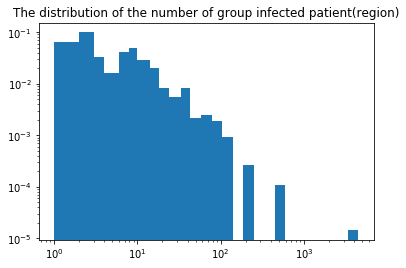

In [4]:
# 그룹감염 case 데이터
g_df=case.loc[case["group"]==True,["province","city","infection_case", "confirmed"]] # case의 그룹데이터만 모은다.
g_df["add"]=g_df.apply(lambda x: "|".join([x["province"],x["city"]]),axis=1) 
add=g_df[["add","confirmed"]].groupby("add").sum() # 시 or 구를 기준으로 데이터를 더한다.

bins=np.round(np.logspace(np.log10(1),np.log10(add.confirmed.max()),endpoint=True,num=30)).tolist()
plt.hist(g_df["confirmed"],bins=bins,density=True)
plt.xscale("log")
plt.yscale("log")
plt.title("The distribution of the number of group infected patient(region)")
plt.show()

비집단 감염 된 환자들의 수(시 혹은 구 기준)의 distribution

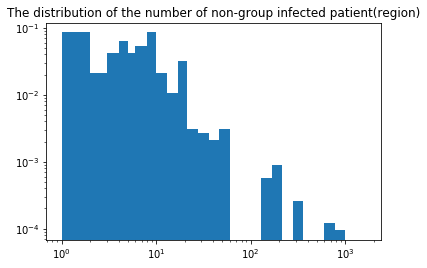

In [5]:
# 비그룹감염 case 데이터
ng_df=case.loc[case["group"]==False,["province","city","infection_case", "confirmed"]] # case의 그룹이 아닌 데이터만 모은다.
ng_df["add"]=ng_df.apply(lambda x: "|".join([x["province"],x["city"]]),axis=1) 
ng_add=ng_df[["add","confirmed"]].groupby("add").sum() # 시 or 구를 기준으로 데이터를 더한다.

bins=np.round(np.logspace(np.log10(1),np.log10(ng_add.confirmed.max()),endpoint=True,num=30)).tolist()
plt.hist(ng_df["confirmed"],bins=bins,density=True)
plt.xscale("log")
plt.yscale("log")
plt.title("The distribution of the number of non-group infected patient(region)")
plt.show()

- 다양한 분류 기준에서 powerlaw의 형태를 보임을 알수 있습니다.

### 1.2  네트워크로 본 코로나 현황(python)

필요한 라이브러리

In [6]:
pip install pyvis

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [8]:
import networkx as nx
from pyvis.network import Network

파일 내려받기

In [9]:
patinfo=pd.read_csv(path+'\\data\\Patientinfo.csv')

필요한 정보들 선택

In [10]:
#집단 감염 케이스
infect_case=list(set(case['infection_case'])-set(['etc','contact with patient','overseas inflow']))
#결측치 채우기
patinfo.fillna('nan',inplace=True)
# 지역 확진번호 리스트
pat_id=list(patinfo['patient_id'])
patient_case=list(patinfo['infection_case'])
#누구로부터 감염됐는가
who=list(patinfo['infected_by'])
#결측치값을 제외, 중복제외
from_who=set(list(patinfo['infected_by']))-set(['nan'])
# 확진자 id를 정수로 변환
from_who=[int(i) for i in from_who]
#전체 확진자들 중 who가 결측 아닌 사람들 인덱스
who_index=[int(i) for i in range(len(pat_id)) if list(patinfo['infected_by'])[i]!='nan' and who[i] in pat_id]
#감염시킨 사람 -> 감염된 확진자
new_edges=[(int(who[i]),int(pat_id[i]))for i in who_index]
#감염장소 ->확진자 연결
num_case=[(patient_case[num],int(pat_id[num])) for num in range(len(pat_id)) if patient_case[num] in infect_case]
#집단감염된 확진자 리스트
patient_list=[i[1] for i in num_case]
#실제 PatientInfo 파일상에 존재하는 집단감염 케이스 목록
case_list=list(set([i[0] for i in num_case]))

필요한 정보들 선택

In [11]:
#확진자의 성별
gender=list(patinfo['sex'])
gender_index=[i for i in range(len(pat_id)) if gender[i]!='nan' and patient_case[i] in infect_case]
#확진자의 나이대
age=list(patinfo['age'])
age_index=[i for i in range(len(pat_id)) if age[i]!='nan' and patient_case[i] in infect_case]

#### 1.2.1 연령대로 보는 집단감염장소-확진자 네트워크

In [12]:
num_case_age=[(int(pat_id[num]),patient_case[num]) for num in range(len(pat_id)) if patient_case[num] in infect_case and age[num]!='nan']
patient_list_age=[i[0] for i in num_case_age]
case_list_age=list(set(np.array(list(patinfo['infection_case']))[np.array(age_index)]))
edge_list_age=num_case_age
list_ind_age=[pat_id.index(i) for i in patient_list_age]

 나이에 따른 확진자 노드 색깔 리스트

In [13]:
col_patients_age=[]
for i in list_ind_age:
    pat_age=list(patinfo['age'])[i]
    age_line=int(patinfo['age'][i][:-1])
    if age_line==90:
        col_patients_age.append('black')
    elif age_line==80:
        col_patients_age.append('brown')
    elif age_line==70:
        col_patients_age.append('red')
    elif age_line==60:
        col_patients_age.append('orange')
    elif age_line==50:
        col_patients_age.append('yellow')
    elif age_line==40:
        col_patients_age.append('green')
    elif age_line==30:
        col_patients_age.append('aqua')
    elif age_line==20:
        col_patients_age.append('blue')
    elif age_line==10:
        col_patients_age.append('indigo')
    else:
        col_patients_age.append('purple')

장소 노드 크기 리스트(나이)

In [14]:
case_list_age

['gym facility in Sejong',
 'Milal Shelter',
 "Eunpyeong St. Mary's Hospital",
 'Suyeong-gu Kindergarten',
 'Gyeongsan Seorin Nursing Home',
 'Pilgrimage to Israel',
 'Cheongdo Daenam Hospital',
 'Changnyeong Coin Karaoke',
 'Guro-gu Call Center',
 'Shincheonji Church',
 'gym facility in Cheonan',
 'Bonghwa Pureun Nursing Home',
 'Gyeongsan Jeil Silver Town',
 'River of Grace Community Church',
 'Onchun Church',
 'Seongdong-gu APT',
 'Geochang Church',
 'Gyeongsan Cham Joeun Community Center',
 'Ministry of Oceans and Fisheries',
 'Dongan Church']

집단감염지 - 확진자 네트워크(나이)

In [15]:
label_patients_age=np.array(list(patinfo['age']))[np.array(list_ind_age)]
size_case_age=[int(np.log(case.loc[case["infection_case"]==i, "confirmed"].values.sum()))*7 for i in case_list_age]

g=Network(height=1050,width=1680,notebook=True)
g.add_nodes(patient_list_age,label=[" "]*len(patient_list_age),color=col_patients_age,size=[10]*len(patient_list_age))
g.add_nodes(case_list_age,color=['gray']*len(case_list_age),title=case_list_age,size=size_case_age)
outcase=list(set(infect_case)-set(case_list_age))
g.add_nodes(outcase,size=[10]*len(outcase),color=['gray']*len(outcase))
g.add_edges(num_case_age)


g.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 100,
      "strokeColor": "rgba(165,215,255,1)"}}}
""")
#g.show('dacon_age.html') #네트워크를 직접 만드시려면 맨 앞의 #을 지우세요.

## [※이 글을 클릭하시면 원본 네트워크 html파일이 저장됩니다. 해당 파일에서 더욱더 상세하게 확인하실 수 있습니다.](http://teamconfidence.dothome.co.kr/wp-content/uploads/2020/04/age-1.html)


![network of age](http://teamconfidence.dothome.co.kr/wp-content/uploads/2020/04/age.png)


* 나이대 별로 집단감염의 네트워크를 그린 결과, 비교적 구로구 콜센터와 신천지 교회에서 다양한 연령대의 감염자가 발생했음을 알수 있습니다.
* 종교집단(동안교회, 온천교회, 신천지)의 감염에서는 20대의 감염비율이 높은 것을 확인할 수 있었습니다.

#### 1.2.2 성별로 보는 집단감염장소-확진자 네트워크

In [16]:
num_case_sex=[(int(pat_id[num]),patient_case[num]) for num in range(len(pat_id)) if patient_case[num] in infect_case and gender[num]!='nan']
patient_list_sex=[i[0] for i in num_case_sex]
case_list_sex=list(set(np.array(list(patinfo['infection_case']))[np.array(gender_index)]))
edge_list_sex=num_case_sex
list_ind_sex=[pat_id.index(i) for i in patient_list_sex]

성별에 따른 확진자 노드 색깔 리스트

In [17]:
col_patients_sex=[]
for i in list_ind_sex:
    pat_gender=list(patinfo['sex'])[i]
    if pat_gender=='male':
        col_patients_sex.append('blue')
    else:
        col_patients_sex.append('red')

장소 노드 크기 리스트(성별)

In [18]:
size_case_sex=[int(np.log(case.loc[case["infection_case"]==i, "confirmed"].values.sum()))*7 for i in case_list_sex]

집단감염지-확진자 네트워크(성별) 

In [19]:
g=Network(height=1050,width=1680,notebook=True)
g.add_nodes(patient_list_sex,color=col_patients_sex,label=[' ']*len(patient_list_sex),size=[10]*len(patient_list_sex))
g.add_nodes(case_list_sex,color=['gray']*len(case_list_sex),label=case_list_sex,size=size_case_sex)
outcase=list(set(infect_case)-set(case_list_sex))
g.add_nodes(outcase,size=[10]*len(outcase),color=['gray']*len(outcase))
g.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 100,
      "strokeColor": "rgba(165,215,255,1)"}}}
""")
g.add_edges(num_case_sex)
#g.show('dacon_sex.html') #네트워크를 직접 만드시려면 맨 앞의 #을 지우세요.

## [※이 글을 클릭하시면 원본 네트워크 html파일이 저장됩니다. 해당 파일에서 더욱더 상세하게 확인하실 수 있습니다.](http://teamconfidence.dothome.co.kr/wp-content/uploads/2020/04/sex-1.html)

![network of sex](http://teamconfidence.dothome.co.kr/wp-content/uploads/2020/04/sex.png)


- 특이한 점은 천안의 체육시설(줌바댄스 교습소)에서는 감염자가 전원 여성임을 확인할 수 있습니다. 이는 운동의 특성에 기인한 것으로 보입니다.  
- 구로 콜센터는 여성 감염자가 많고, 해양수산부에서는 남성 감염자가 많이 발생했음을 확인할 수 있습니다. 

#### 1.2.3 확진자 간의 접촉을 포함한 집단감염장소-확진자 네트워크

새로운 경우들(확진자 간의 접촉) 추가

In [20]:
new_nodes_1=[i[0] for i in new_edges if i[0] not in patient_list]
new_nodes_2=[i[1] for i in new_edges if i[1] not in patient_list]
patient_list.extend(new_nodes_1)
patient_list.extend(new_nodes_2)
patient_list=list(set(patient_list))
edge_list=list(num_case)
edge_list.extend(new_edges)

Filter(최소 node 개수 =6개)

In [21]:
G=nx.Graph()
G.add_nodes_from(patient_list,bipartite=1)
G.add_nodes_from(case_list,bipartite=0)
G.add_edges_from(edge_list)

components_covid=[x for x in sorted(nx.connected_components(G),key=len,reverse=True)]
num_node_compo=[len(x) for x in sorted(nx.connected_components(G),key=len,reverse=True)]
first=num_node_compo.index(5)
smaller=components_covid[first:]
trash=set()
for i in smaller:
    trash=trash|i
patient_list=list(set(patient_list)-trash)   
case_list=list(set(case_list)-trash)
edge_list=[i for i in edge_list if i[0] not in list(trash) and i[1] not in list(trash)]
#확진자들의 인덱스
list_ind=[pat_id.index(i) for i in patient_list]

확진날짜 구해주는 함수

In [22]:
#함수로 해놔야 나중에 편해진다!
def get_date(pati_id):
    index=pat_id.index(pati_id)
    str_day=list(patinfo['confirmed_date'])[index]
    str_day=str_day.split('-')
    date=''.join(str_day)
    date=int(date)
    return date

집단감염의 최초확진자

In [23]:
dict_51={}
for i in case_list:
    dict_51[i]=list(set(G[i])-set(case_list))
    
for i in case_list:
    date=[get_date(j) for j in dict_51[i]]
    first_infected=[dict_51[i][k] for k in range(len(date)) if date[k]==min(date)]
    for k in first_infected:
        edge_list=list(set(edge_list)-set([(i,k)]))
        edge_list.append((k,i))

지역에 따른 환자 노드 색깔 리스트

In [24]:
col_patients=[]
for i in list_ind:
    region=int(str(list(patinfo['patient_id'])[i])[:2])
    if region==10:
        col_patients.append('red')
    elif region==11:
        col_patients.append('aqua')
    elif region==12:
        col_patients.append('green')
    elif region==13:
        col_patients.append('purple')
    elif region==14:
        col_patients.append('orange')
    elif region==15:
        col_patients.append('lawngreen')
    elif region==16:
        col_patients.append('blue')
    elif region==17:
        col_patients.append('yellow')
    elif region==20:
        col_patients.append('crimson')
    elif region==30:
        col_patients.append('coral')
    elif region==40:
        col_patients.append('yellowgreen')
    elif region==41:
        col_patients.append('limegreen')
    elif region==50:
        col_patients.append('plum')
    elif region==51:
        col_patients.append('darkmagenta')
    elif region==60:
        col_patients.append('springgreen')
    else:
        col_patients.append('deepskyblue')

지역에 따른 환자 노드 이름 리스트

In [25]:
label_patients=[]
for i in list_ind:
    region=int(str(list(patinfo['patient_id'])[i])[:2])
    number=int(str(list(patinfo['patient_id'])[i])[4:])
    if region==10:
        label_patients.append('Seoul_%d' %number)
    elif region==11:
        label_patients.append('Busan_%d' %number)
    elif region==12:
        label_patients.append('Daegu_%d' %number)
    elif region==13:
        label_patients.append('Gwangju_%d' %number)
    elif region==14:
        label_patients.append('Incheon_%d' %number)
    elif region==15:
        label_patients.append('Daejeon_%d' %number)
    elif region==16:
        label_patients.append('Ulsan_%d' %number)
    elif region==17:
        label_patients.append('Sejong_%d' %number)
    elif region==20:
        label_patients.append('Gyeonggi_%d' %number)
    elif region==30:
        label_patients.append('Gangwon_%d' %number)
    elif region==40:
        label_patients.append('Chungbuk_%d' %number)
    elif region==41:
        label_patients.append('Chungnam_%d' %number)
    elif region==50:
        label_patients.append('Jeonbuk_%d' %number)
    elif region==51:
        label_patients.append('Jeonnam_%d' %number)
    elif region==60:
        label_patients.append('Gyeongbuk_%d' %number)
    else:
        label_patients.append('Gyeongnam_%d' %number)

집단감염지 노드 크기

In [26]:
size_case=[int(np.log(case.loc[case["infection_case"]==i, "confirmed"].values.sum()))*7 for i in case_list]

#### 네트워크 그리기

In [27]:
g=Network(height=1050,width=1680,directed=True,notebook=True)
g.add_nodes(patient_list,color=col_patients,label=[' ']*len(patient_list),title=label_patients,size=[10]*len(patient_list))
g.add_nodes(case_list,color=['gray']*len(case_list),title=case_list,size=size_case)
outcase=list(set(infect_case)-set(case_list))
g.add_nodes(outcase,size=[10]*len(outcase),color=['gray']*len(outcase))
g.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 100,
      "strokeColor": "rgba(165,215,255,1)"}}}
""")
for i in edge_list:
        g.add_edge(source=i[0],to=i[1])
#g.show('contact_group_modi.html') #네트워크를 직접 만드시려면 맨 앞의 #을 지우세요.

## [※이 글을 클릭하시면 원본 네트워크 html파일이 저장됩니다. 해당 파일에서 더욱더 상세하게 확인하실 수 있습니다.](http://teamconfidence.dothome.co.kr/wp-content/uploads/2020/04/region-1.html)

![legend of region](http://teamconfidence.dothome.co.kr/wp-content/uploads/2020/04/region.png)

- 빨간색(서울)-보라색(광주)이며, 서울에서 멀어질수록 색상도 빨간색에서 멀어지도록 만들었습니다.
- 다른 집단감염지와 달리 유독 신천지에 다양한 지역의 확진자가 있음을 볼 수 있습니다.
- 구로콜센터에서 edge(선)가 길게 나온 빨간색 node(원)는 서울125 환자입니다.(node를 길게 클릭하면 환자번호를 확인할 수 있습니다) 구로콜센터에서 감염된 서울125번 환자가 20명을 감염시켰음을 알 수 있고, 20명 중 한명이 또 다시 약 30명의 감염자를 발생시켜 **연쇄감염이 일어났음을 알 수 있습니다.**
- 특히 신천지는 개인 간의 연쇄감염뿐만 아니라 **고창교회와 창녕 코인노래방 등 집단을 감염 시켰음을 확인할 수 있습니다.**

#### 1.2.4 지도네트워크로 본 코로나 현황

In [28]:
region=pd.read_csv(path+r'\data\region.csv')
d=case.apply(lambda x: "|".join([x["infection_case"],x["latitude"],x["longitude"]]), axis=1)

In [29]:
lan_list=[]
for i in d:
    if i[-1]!="-":
        lan_list.append(i)
    else: pass
place=[]
lat=[]
long=[]
for i in lan_list:
    place.append(i.split("|")[0])
    lat.append(i.split("|")[1])
    long.append(i.split("|")[2])
case_address=pd.DataFrame(data={"infection case": place, "latitude": lat, "longitude":long})
dump=pinfo.loc[(pinfo["city"]=="etc")|(pinfo["city"].isna()),"city"]

for i in dump.index:
    pinfo.loc[i,"city"]=pinfo["province"][i]

pinfo["address"]=pinfo.apply(lambda x: "|".join([str(x["province"]),str(x["city"])]),axis=1) #환자 정보의 시+구
region["address"]=region.apply(lambda x: "|".join([str(x["province"]),str(x["city"])]),axis=1)#지역의 시+구
df=pinfo[["infection_case", "address","patient_id"]].groupby(["infection_case","address"]).count().reset_index()
#각 케이스별로 주소지의 확진자수 집계
# 환자정보가 있는 케이스만 c에 입력
c=[]
for i in case_address["infection case"]:
    ad=pinfo.loc[pinfo["infection_case"]==i,"address"].nunique()
    if ad!=0:
        c.append(i)
    else: pass

In [30]:
# infection_case의 overseas inflow는 일단 제외한다. 
group=case.loc[(case["group"]==True), "infection_case"].unique().tolist()
non_group=case.loc[(case["group"]==False)&(case["infection_case"]!='overseas inflow'), "infection_case"].unique().tolist() #
group_df=df.loc[df["infection_case"].isin(group)]
ngroup_df=df.loc[df["infection_case"].isin(non_group)]
ng=ngroup_df[["address","patient_id"]].groupby("address").sum().reset_index()
ng.columns=["address","non_group_patient"]

gr=group_df[["address","patient_id"]].groupby("address").sum().reset_index()
gr.columns=["address","group_patient"]

df_region=pd.merge(ng,gr, how="outer", on="address").fillna(0)
df_region["province"]=df_region["address"].map(lambda x: x.split("|")[0])
df_region["city"]=df_region["address"].map(lambda x: x.split("|")[1])


In [31]:
def make_feature_group(case_name,u,group_n): #case별로 각각의 feature group을 만들어서 네트워크 만들기

    case_lat=float(case_address.loc[case_address["infection case"]==case_name,"latitude"])
    case_long=float(case_address.loc[case_address["infection case"]==case_name, "longitude"])
    #map_case=folium.Map(location=[case_lat, case_long],zoom_start=11,tiles="Cartodb Positron")

    df2=df.loc[df["infection_case"]==case_name]
    df3=pd.merge(df2,region[["address","latitude","longitude"]], how="left",on="address")
    region_count=df3.patient_id.count()
    folium.Marker(location=[case_lat,case_long],popup="case: %s / region of infected patients:%d"%(case_name, region_count),icon=folium.Icon(color='red',icon="star")).add_to(group_n)

    for i in df3.index:
        patient_lat=float(df3["latitude"][i])
        patient_long=float(df3["longitude"][i])
        patient_num=int(df3["patient_id"][i])
        folium.PolyLine(weight=patient_num/2,locations=[(case_lat,case_long),(patient_lat, patient_long)],smooth_factor=10,color=color_[u]).add_to(group_n)

    

In [32]:
ko_states=json.load(open(path+r"\map\skorea-municipalities-2018-topo-simple.json", encoding="utf-8"))

In [33]:
lst_all,lst_in,lst_out=[],[],[]
for i in range(len(ko_states["objects"]["skorea_municipalities_2018_geo"]["geometries"])):
    u=ko_states["objects"]["skorea_municipalities_2018_geo"]["geometries"][i]["properties"]["name_eng"]
    lst_all.append(u)
    if u in region["city"].tolist():
        lst_in.append(u)
    else: 
        lst_out.append(u)

In [34]:
city_={"Sejongsi":"Sejong", "Suwonsijangangu" :"Suwon-si","Suwonsigwonseongu":"Suwon-si","Suwonsipaldalgu":"Suwon-si","Suwonsiyeongtonggu" : "Suwon-si",
       "Seongnamsisujeonggu":"Seongnam-si","Seongnamsijungwongu":"Seongnam-si","Seongnamsibundanggu":"Seongnam-si",
       "Anyangsimanangu":"Anyang-si","Anyangsidongangu": "Anyang-si","Ansansisangnokgu":"Ansan-si","Ansansidanwongu":"Ansan-si",
       "Goyangsideogyanggu":"Goyang-si","Goyangsiilsandonggu":"Goyang-si" ,"Goyangsiilsanseogu":"Goyang-si",
       "Yonginsicheoingu":"Yongin-si","Yonginsigiheunggu":"Yongin-si","Yonginsisujigu":"Yongin-si", "Hwaseongsi": "Hwaseong-si", 
       "Yangjusi":"Yangju-si","Pocheonsi":"Pocheon-si","Cheongjusisangdanggu":"Cheongju-si","Cheongjusiseowongu":"Cheongju-si",
       "Cheongjusiheungdeokgu":"Cheongju-si","Cheongjusicheongwongu":"Cheongju-si","Jeungpyeonggun":"Jeungpyeong-gun",
       "Cheonansidongnamgu":"Cheonan-si","Cheonansiseobukgu":"Cheonan-si","Gyeryongsi":"Gyeryong-si","Dangjinsi":"Dangjin-si",
       "Jeonjusiwansangu":"Jeonju-si","Jeonjusideokjingu":"Jeonju-si","Uichanggu":"Changwon-si","Seongsangu":"Changwon-si",
       "Masanhappogu":"Changwon-si","Masanhoewongu":"Changwon-si", "Jinhaegu":"Changwon-si","Jeju-si": "Jeju-do","Seogwipo-si":"Jeju-do"}
city_keys=list(city_.keys())

In [35]:
for i in range(len(ko_states["objects"]["skorea_municipalities_2018_geo"]["geometries"])):
    u=ko_states["objects"]["skorea_municipalities_2018_geo"]["geometries"][i]["properties"]["name_eng"]
    if u in city_keys:
        print(ko_states["objects"]["skorea_municipalities_2018_geo"]["geometries"][i]["properties"])
        ko_states["objects"]["skorea_municipalities_2018_geo"]["geometries"][i]["properties"]["name_eng"]=city_[u]
        print(ko_states["objects"]["skorea_municipalities_2018_geo"]["geometries"][i]["properties"])
        print("---"*30)

    else:pass

{'name': '세종시', 'base_year': '2018', 'name_eng': 'Sejongsi', 'code': '29010'}
{'name': '세종시', 'base_year': '2018', 'name_eng': 'Sejong', 'code': '29010'}
------------------------------------------------------------------------------------------
{'name': '수원시장안구', 'base_year': '2018', 'name_eng': 'Suwonsijangangu', 'code': '31011'}
{'name': '수원시장안구', 'base_year': '2018', 'name_eng': 'Suwon-si', 'code': '31011'}
------------------------------------------------------------------------------------------
{'name': '수원시권선구', 'base_year': '2018', 'name_eng': 'Suwonsigwonseongu', 'code': '31012'}
{'name': '수원시권선구', 'base_year': '2018', 'name_eng': 'Suwon-si', 'code': '31012'}
------------------------------------------------------------------------------------------
{'name': '수원시팔달구', 'base_year': '2018', 'name_eng': 'Suwonsipaldalgu', 'code': '31013'}
{'name': '수원시팔달구', 'base_year': '2018', 'name_eng': 'Suwon-si', 'code': '31013'}
----------------------------------------------------------------

In [36]:
df_re=region.loc[~region["city"].isin(df_region["city"]),["province","city"]].copy()

In [37]:
dummy_=np.repeat(0,df_re.shape[0])
non_p=pd.DataFrame(data={"address":dummy_, "non_group_patient":dummy_, "group_patient":dummy_, "province":df_re["province"],"city":df_re["city"]})
df_region=pd.concat([df_region, non_p])

In [38]:
color_=["#FE0606","#FE6B06","#FBD900","#3BB900","#0022B9","#000A6D","#7F02C8","#C802C5","#95FF00","#00F9FF","#298B8B","#6F5A0B","#939B98","#546F9C","#000000","#78DFC2","#FF6E00","#C0FF00","#415600"]

map_case=folium.Map(location=[36,129],zoom_start=7,tiles="Cartodb Positron")

#path=r"C:\Users\hyde2\py_coding\covid_19\map"
#ko_states=json.load(open(path+r"\\skorea-municipalities-2018-topo-simple.json", encoding="utf-8"))

folium.Choropleth(
    geo_data=ko_states,
    data=df_region,
    columns=["city",'non_group_patient'],
    key_on="properties.name_eng",topojson="objects.skorea_municipalities_2018_geo",fill_color='PuRd',
    legend_name='non-group confirmed',
).add_to(map_case)

group0 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[0],c[0]))
make_feature_group(c[0],0,group0)
group0.add_to(map_case)

group1 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[1],c[1]))
make_feature_group(c[1],1,group1)
group1.add_to(map_case)

group2 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[2],c[2]))
make_feature_group(c[2],2,group2)
group2.add_to(map_case)

group3 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[3],c[3]))
make_feature_group(c[3],3,group3)
group3.add_to(map_case)

group4 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[4],c[4]))
make_feature_group(c[4],4,group4)
group4.add_to(map_case)

group5 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[5],c[5]))
make_feature_group(c[5],5,group5)
group5.add_to(map_case)

group6 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[6],c[6]))
make_feature_group(c[6],6,group6)
group6.add_to(map_case)

group7 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[7],c[7]))
make_feature_group(c[7],7,group7)
group7.add_to(map_case)

group8 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[8],c[8]))
make_feature_group(c[8],8,group8)
group8.add_to(map_case)

group9 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[9],c[9]))
make_feature_group(c[9],9,group9)
group9.add_to(map_case)

group10 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[10],c[10]))
make_feature_group(c[10],10,group10)
group10.add_to(map_case)

group11 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[11],c[11]))
make_feature_group(c[11],11,group11)
group11.add_to(map_case)

group12 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[12],c[12]))
make_feature_group(c[12],12,group12)
group12.add_to(map_case)

group13 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[13],c[13]))
make_feature_group(c[13],13,group13)
group13.add_to(map_case)

group14 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[14],c[14]))
make_feature_group(c[14],14,group14)
group14.add_to(map_case)

group15 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[15],c[15]))
make_feature_group(c[15],15,group15)
group15.add_to(map_case)

group16 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[16],c[16]))
make_feature_group(c[16],16,group16)
group16.add_to(map_case)

group17 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[17],c[17]))
make_feature_group(c[17],17,group17)
group17.add_to(map_case)

group18 = folium.FeatureGroup(name='<span style=\\"color: %s;\\">%s</span>'%(color_[18],c[18]))
make_feature_group(c[18],18,group18)
group18.add_to(map_case)


dummy=pd.pivot_table(df.loc[df["infection_case"].isin(c)], index=["address","infection_case"]).reset_index()
add=dummy["address"].unique()

df_dum=pd.merge(dummy,region[["address","latitude","longitude"]], how="left",on="address")

for i in add:

    pop_up=df_dum.loc[df_dum["address"]==i,["address","infection_case","patient_id"]]
    pop_up.columns=["address","infection_case","confirmed"]
    html = pop_up.to_html(classes='table table-striped table-hover table-condensed table-responsive')
    patient_marker_lat=df_dum.loc[df_dum["address"]==i,"latitude"].unique()[0]
    patient_marker_lng=df_dum.loc[df_dum["address"]==i,"longitude"].unique()[0]
    folium.CircleMarker([patient_marker_lat,patient_marker_lng],radius=3,popup=html,color="blue").add_to(map_case)

folium.map.LayerControl('topright', collapsed=False).add_to(map_case)

map_case.save("layercontrol_map.html")
map_case

- 별모양의 마커는 집단감염지를 나타냈고, 파란색 node(원)는 집단에서 감염된 환자들의 거주지를 나타냅니다. 그리고 지도의 색이 붉을수록 비집단 감염자의 수가 많음을 나타냅니다. 
- 신천지 체크박스를 해제하면, 지도 상의 많은 edge(선)이 사라짐을 알 수 있습니다. 이는 역으로 신천지가 전국적으로 넓은 지역에 감염자를 확산시켰음을 알 수 있습니다.
- 집단감염이 많이 일어난 지역의 주변에는 비집단감염도 많이 일어남을 확인할 수 있었습니다.

#### 1.2.5 지역별 집단 감염자 수와 비집단 감염자 수의 상관계수

In [39]:
pp=df_region[["province","non_group_patient","group_patient"]].groupby("province").sum()
pp.head()

,non_group_patient,group_patient
province,,
Busan,59.0,42.0
Chungcheongbuk-do,40.0,0.0
Chungcheongnam-do,101.0,28.0
Daegu,1.0,13.0
Daejeon,29.0,1.0


In [40]:
print("집단감염자와 비집단감염자의 상관계수:",pp["non_group_patient"].corr(pp["group_patient"]))

집단감염자와 비집단감염자의 상관계수: 0.5171164068931398


- 지역(광역시 혹은 도)별 비집단 감염자와 집단감염자의 상관계수를 구한 결과 0.5로 양의 상관관계를 보였습니다. 이를 통해 지역의 집단감염자가 증가할때 비집단감염자의 수도 함께 증가하는 경향이 있음을 알 수 있습니다.

## 2. 통계 분석 - 사회적 거리두기는 확진자수 감소에 도움을 줄까?

### 2.1 모델링을 위한 EDA (R)

In [1]:
options(digits = 22)
library(dplyr) #for data manipulation
library(ggplot2) #for visualization
library(gghighlight) #for visualization
library(gridExtra) #for visualization
library(car) #for VIF
library(lmtest) # for durbinwatson test
library(gdata) # for variable selection

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'gghighlight' was built under R version 3.6.3"Warning message:
"package 'gridExtra' was built under R version 3.6.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Warning message:
"package 'car' was built under R version 3.6.3"Loading required package: carData

Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode

Warning message:
"package 'lmtest' was built under R version 3.6.3"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.6.3"
Attaching package: 'zoo'

The following objects are masked from 'package:

In [2]:
#data loading

path=getwd()

case <- read.csv(paste0(path,"/data/Case.csv"))
patientinfo<-read.csv(paste0(path,"/data/PatientInfo.csv"),stringsAsFactors = FALSE)
patientroute<-read.csv(paste0(path,"/data/PatientRoute.csv"))
region<-read.csv(paste0(path,"/data/region.csv"))
searchtrend<-read.csv(paste0(path,"/data/SearchTrend.csv"))
seoulfloating<-read.csv(paste0(path,"/data/SeoulFloating.csv"),stringsAsFactors = FALSE)
time<-read.csv(paste0(path,"/data/Time.csv"),stringsAsFactors = FALSE)
timeage<-read.csv(paste0(path,"/data/TimeAge.csv"))
timegender<-read.csv(paste0(path,"/data/TimeGender.csv"))
timeprovince<-read.csv(paste0(path,"/data/TimeProvince.csv"))
weather<-read.csv(paste0(path,"/data/Weather.csv"),stringsAsFactors = FALSE)

head(patientinfo)
head(case)
head(time)

patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1000000001,2,male,1964,50s,Korea,Seoul,Gangseo-gu,NA,overseas inflow,1,NA,75,2020-01-22,2020-01-23,2020-02-05,,released
1000000002,5,male,1987,30s,Korea,Seoul,Jungnang-gu,NA,overseas inflow,1,NA,31,,2020-01-30,2020-03-02,,released
1000000003,6,male,1964,50s,Korea,Seoul,Jongno-gu,NA,contact with patient,2,2002000001,17,,2020-01-30,2020-02-19,,released
1000000004,7,male,1991,20s,Korea,Seoul,Mapo-gu,NA,overseas inflow,1,NA,9,2020-01-26,2020-01-30,2020-02-15,,released
1000000005,9,female,1992,20s,Korea,Seoul,Seongbuk-gu,NA,contact with patient,2,1000000002,2,,2020-01-31,2020-02-24,,released
1000000006,10,female,1966,50s,Korea,Seoul,Jongno-gu,NA,contact with patient,3,1000000003,43,,2020-01-31,2020-02-19,,released


case_id,province,city,group,infection_case,confirmed,latitude,longitude
1000001,Seoul,Guro-gu,TRUE,Guro-gu Call Center,98,37.508163,126.884387
1000002,Seoul,Dongdaemun-gu,TRUE,Dongan Church,20,37.592888,127.056766
1000003,Seoul,Guro-gu,TRUE,Manmin Central Church,41,37.481059,126.894343
1000004,Seoul,Eunpyeong-gu,TRUE,Eunpyeong St. Mary's Hospital,14,37.63369,126.9165
1000005,Seoul,Seongdong-gu,TRUE,Seongdong-gu APT,13,37.55713,127.0403
1000006,Seoul,Jongno-gu,TRUE,Jongno Community Center,10,37.57681,127.006


date,time,test,negative,confirmed,released,deceased
2020-01-20,16,1,0,1,0,0
2020-01-21,16,1,0,1,0,0
2020-01-22,16,4,3,1,0,0
2020-01-23,16,22,21,1,0,0
2020-01-24,16,27,25,2,0,0
2020-01-25,16,27,25,2,0,0


In [3]:
sum(duplicated(patientinfo$patient_id)) #중복 없음 확인

[1] 0

#### 2.1.1 인구학적 정보로 알아보는 코로나 현황

In [4]:
case$infection_case <- as.character(case$infection_case)

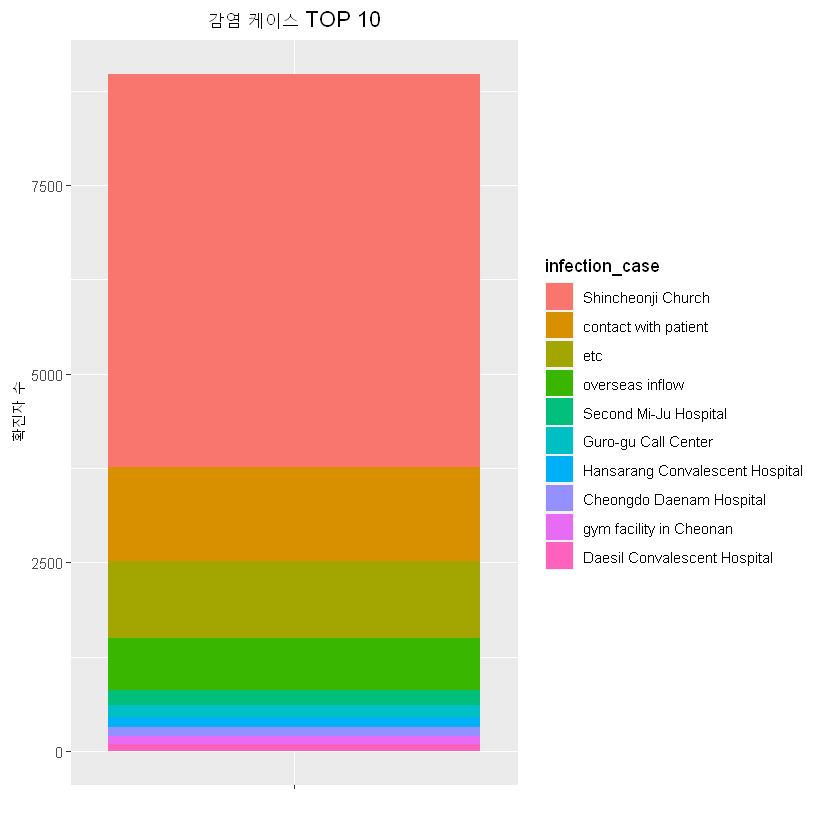

In [5]:
dat1 <- case%>%
    group_by(infection_case)%>%
    summarize(
    sum = sum(confirmed))
top10 <- dat1[order(dat1$sum, decreasing = T),]
top10 <- top10[1:10,]

top10 <- transform(top10, 
         infection_case = factor(infection_case, levels = top10$infection_case))

ggplot(data=top10, aes(x="",y=sum, fill=infection_case)) +
  geom_bar(stat = "identity", width=1) +
  ggtitle("감염 케이스 TOP 10") +
  labs(x = "", y = "확진자 수") +
theme(plot.title = element_text(hjust = 0.5)) 

- Case.csv 데이터를 활용한 감염경로 **top10** 입니다.
- 예상과 같이 집단감염 중 신천지가 제일 많은 빈도를 차지하고 있었습니다.

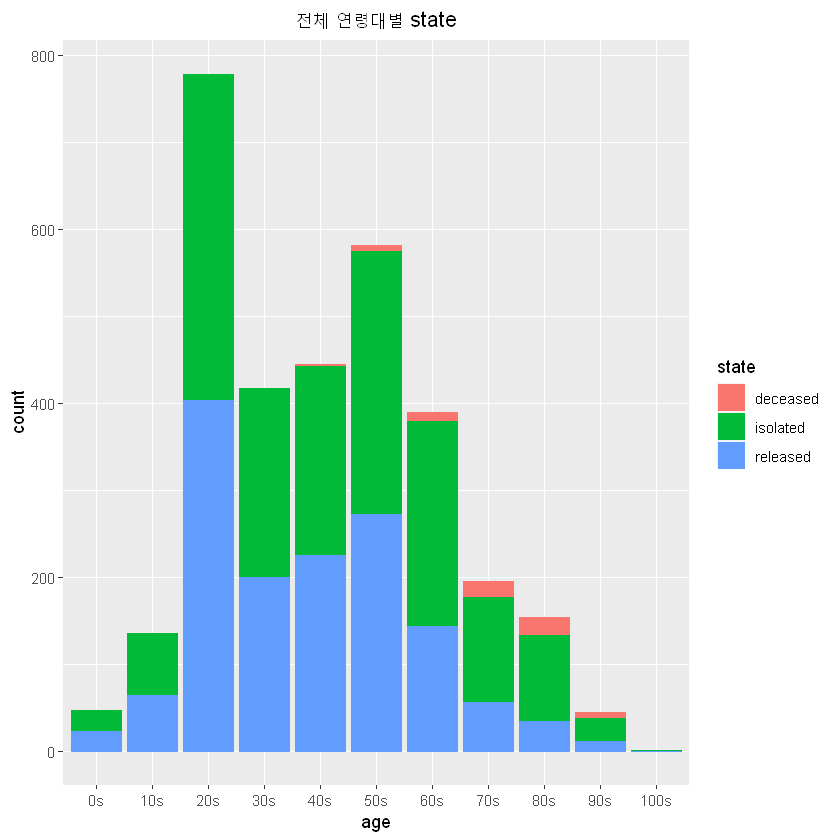

In [6]:
dat1<-patientinfo%>%
    group_by(age, state)%>%
    summarise(
    count=n()) #연령대별 state 빈도 테이블

standard_table <- data.frame(state = rep(c("deceased", "isolated", "released"), each = 11), age = rep(c("0s", "10s", "20s", "30s", "40s", "50s", "60s","70s", "80s","90s", "100s"), 3)) #데이터 merge를 위한 기준테이블

standard_table$age <- as.character(standard_table$age)
standard_table$state <- as.character(standard_table$state)

dat2 <- left_join(standard_table, dat1, by=c("state", "age"))
dat2$count<- ifelse(is.na(dat2$count), 0, dat2$count)
p1 = dat2 %>% filter(state %in% c("deceased", "isolated", "released")) %>%
  ggplot(aes(x=age, y=count, color = state, group = state, fill = state)) +
  geom_bar(stat = "identity") +
  scale_x_discrete(limits = c("0s", "10s", "20s", "30s", "40s", "50s", "60s",
                              "70s", "80s", "90s", "100s")) +
  ggtitle("전체 연령대별 state") +
  theme(plot.title = element_text(hjust = 0.5))
p1

- 연령대별로 확진 환자의 상태(사망/격리중/완치)를 나타낸 그래프입니다.
- 20대의 확진자수가 가장 많은것을 확인 할 수 있습니다.

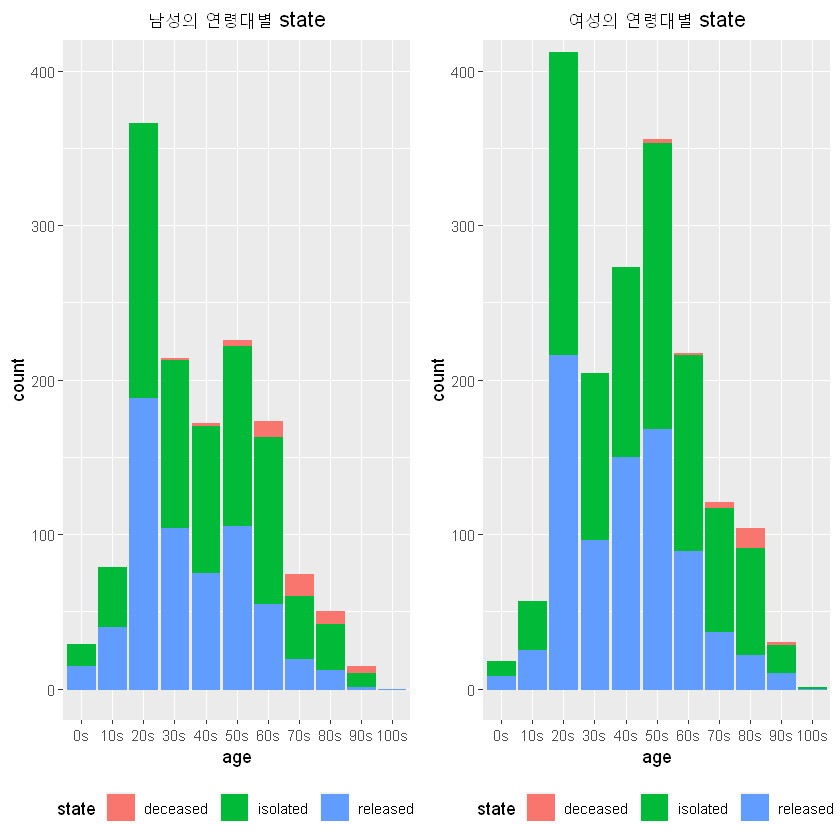

In [7]:
patientinfo <- patientinfo[patientinfo$sex != "unknown",] # sex unknown 제거 

## for male
dat_male <- patientinfo[patientinfo$sex == "male",]
dat1<-dat_male%>%
    group_by(age, state)%>%
    summarise(
    count=n()) 
dat2 <- left_join(standard_table, dat1, by=c("state", "age"))
dat2$count<- ifelse(is.na(dat2$count), 0, dat2$count)

p1 <- dat2 %>% filter(state %in% c("deceased", "isolated", "released")) %>%
  ggplot(aes(x=age, y=count, color = state, group = state, fill = state)) +
  geom_bar(stat = "identity") +
  scale_x_discrete(limits = c("0s", "10s", "20s", "30s", "40s", "50s", "60s",
                              "70s", "80s", "90s", "100s")) +
  ggtitle("남성의 연령대별 state") +
  theme(plot.title = element_text(hjust = 0.5)) +
  coord_cartesian(ylim = c(0,400)) + theme(legend.position = "bottom")

## for female
dat_female <- patientinfo[patientinfo$sex == "female",]

dat3 <- dat_female%>%
    group_by(age, state)%>%
    summarise(
    count=n())

dat4 <- left_join(standard_table, dat3, by=c("state", "age"))
dat4$count<- ifelse(is.na(dat4$count), 0, dat4$count)

p2 <- dat4 %>% filter(state %in% c("deceased", "isolated", "released")) %>%
  ggplot(aes(x=age, y=count, color = state, group = state, fill = state)) +
  geom_bar(stat = "identity") +
  scale_x_discrete(limits = c("0s", "10s", "20s", "30s", "40s", "50s", "60s",
                              "70s", "80s", "90s", "100s")) +
  ggtitle("여성의 연령대별 state") +
  theme(plot.title = element_text(hjust = 0.5)) + 
  coord_cartesian(ylim = c(0,400)) + theme(legend.position = "bottom")

grid.arrange(p1, p2, ncol = 2)

- 남성과 여성 각각에 대한 연령대별 확진 환자의 상태를(사망/격리중/완치) 나타낸 그래프입니다.
- 각 group에서도 20대의 확진자 수가 가장 높았습니다.
- 여성이 남성에 비해 4-50대의 확진환자수가 많은 것을 확인할 수 있습니다.

#### 2.1.2 지역 정보로 알아보는 코로나 현황 

label_key: province


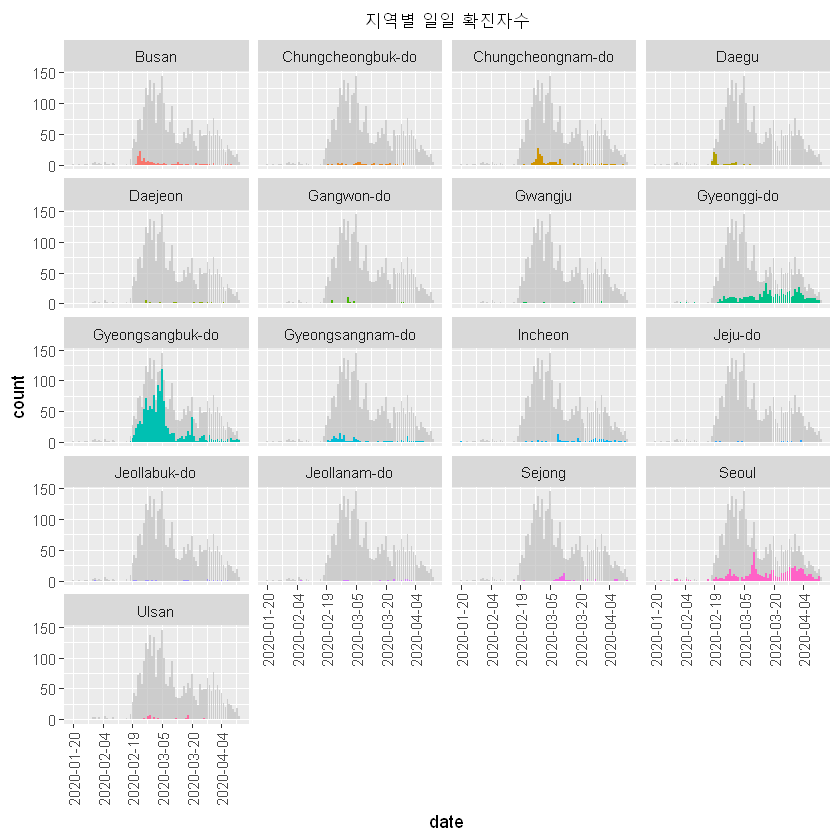

In [8]:
#지역별 일별 확진자수
dat <- patientinfo

table = dat %>%
  group_by(province,confirmed_date) %>%
  summarize(count = n())

table$confirmed_date <- as.Date(table$confirmed_date)

datebreaks <- seq(as.Date("2020-01-20"), as.Date("2020-04-30"), by="15 day")

ggplot(table, aes(x = confirmed_date, y = count, fill = province)) +
  geom_bar(stat='identity') +
  gghighlight() +
  facet_wrap(~ province, ncol = 4) +
ggtitle("지역별 일일 확진자수") +
theme(plot.title = element_text(hjust = 0.5)) + labs(x = "date", y = "count") +
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5 )) + scale_x_date(breaks=datebreaks) +theme(axis.text.x = element_text(angle=90, hjust=1))

- 지역별 확진자수의 추이를 확인한 그래프 입니다.
- 전체 확진자 수에서 각 지역이 차지하는 비중을 표현하였습니다.

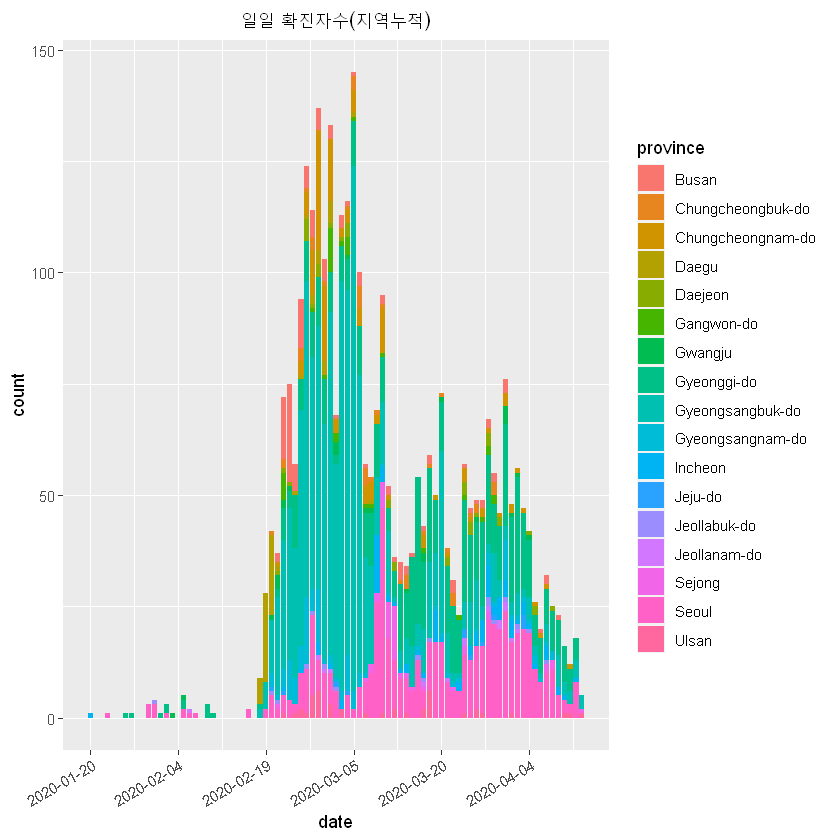

In [9]:
p1 = ggplot(table, aes(x = confirmed_date, y = count, fill = province)) +
  geom_bar(stat='identity') +
 # gghighlight() +
ggtitle("일일 확진자수(지역누적)") +
theme(plot.title = element_text(hjust = 0.5)) + labs(x = "date", y = "count") + scale_x_date(breaks=datebreaks) +theme(axis.text.x = element_text(angle=30, hjust=1))

p1

#### 2.1.3 유동량은 줄었을까?

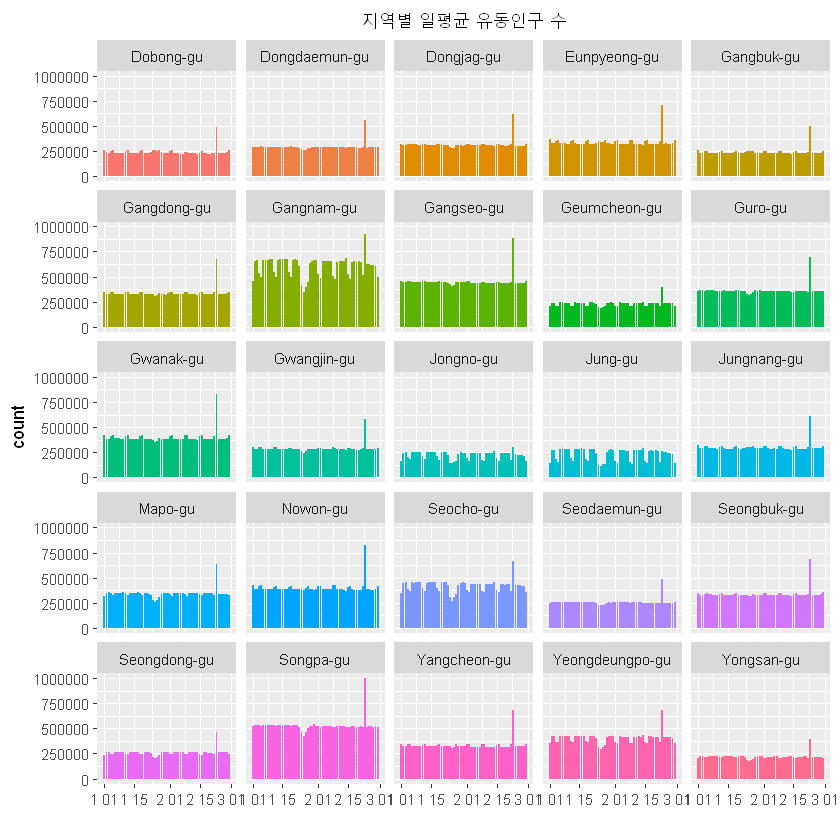

In [10]:
seoulfloating$date <- as.Date(seoulfloating$date)
seoulfloating$wday = weekdays(as.Date(seoulfloating$date))

seoulfloating %>%
  group_by(date, city) %>%
  summarize(mean_num = sum(fp_num)/24) %>%
ggplot(aes(x = date, y = mean_num, fill = city)) +
  geom_bar(stat='identity') +
theme(legend.title = element_blank()) +  
theme(legend.position = 'none') + 
  facet_wrap(~ city, ncol = 5) + labs(x = "", y = "count") +
ggtitle("지역별 일평균 유동인구 수") + theme(plot.title = element_text(hjust = 0.5))

- 서울의 유동인구데이터를 활용하여 일별 유동인구 추이를 확인한 그래프입니다.
- 산업군이 많은 '강남구', '종로구', '중구', '서초구' 등의 지역에서 평일과 주말의 유동인구 차이를 확인할 수 있습니다.
- 소수의 지역구를 제외하고 **2월 23일**에 비정상적으로 유동인구수가 많은 것을 확인할 수 있습니다.

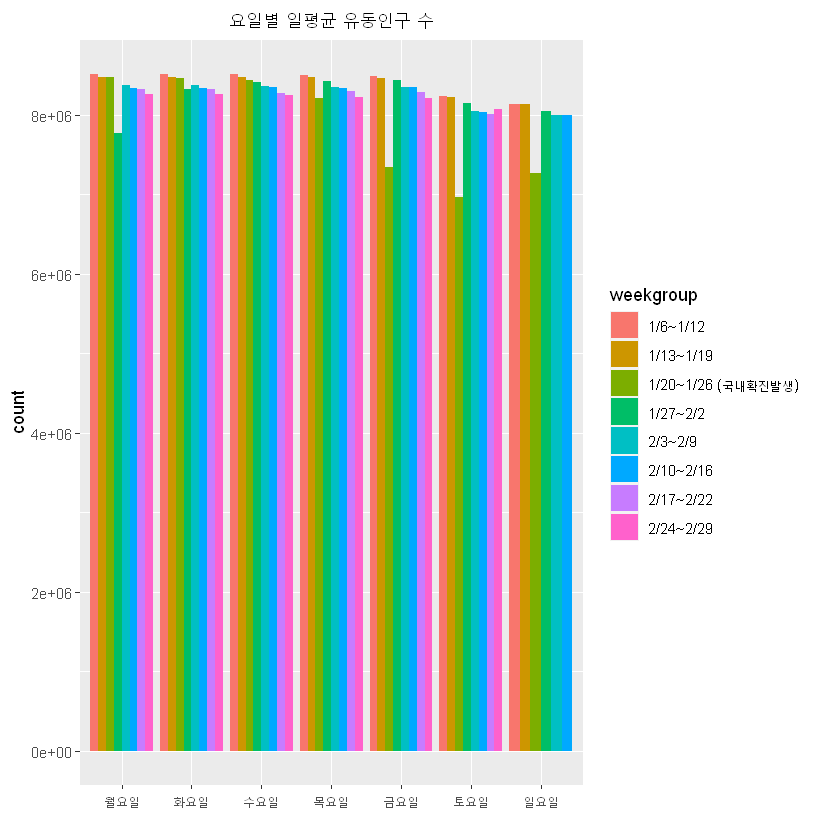

In [11]:
sdata <- seoulfloating[seoulfloating$date >= '2020-01-06',]
sdata$weekgroup =c(rep(c('1/6~1/12','1/13~1/19','1/20~1/26 (국내확진발생)','1/27~2/2','2/3~2/9','2/10~2/16','2/17~2/22'), each=7200*7), rep('2/24~2/29', 7200*6))

tmp = as.data.frame(sdata[sdata$date != '2020-02-23',] %>%
                group_by(wday, weekgroup) %>%
                summarize(count = sum(fp_num)/24)) 
transform(tmp,weekgroup = factor(weekgroup, levels = c('1/6~1/12','1/13~1/19','1/20~1/26 (국내확진발생)','1/27~2/2','2/3~2/9','2/10~2/16','2/17~2/22','2/24~2/29') )) %>%
  ggplot(aes(x = wday, y = count))+
  geom_bar(aes(fill = weekgroup), 
           stat="identity", 
           position='dodge') +
  scale_x_discrete(limits = c('월요일','화요일','수요일','목요일','금요일','토요일','일요일')) +  labs(x = "", y = "count") +
ggtitle("요일별 일평균 유동인구 수") + theme(plot.title = element_text(hjust = 0.5))

- 일일 시간당 평균 유동인구를 요일별, weekgroup별로 표현한 그래프 입니다.
- 국내 확진자의 최초 발생일인 **1월 20일(월요일)을 기준으로 발생 2주 전부터** 그 이후의 추이를 확인하였습니다.
- 전반적으로 weekgroup에 따른 평균 유동인구수가 줄어드는 것을 확인할 수 있습니다.
- 국내확진발생 직후의(1/24~1/26) 금,토,일과 그 다음주 월요일은 설연휴 기간이였기 때문에 다른날에 비해 유독 유동인구수가 적은 것을 확인할 수 있습니다.
- 사실 해당 값은 일일 시간당 서울에 있었던 사람들의 수라고 생각할 수 있습니다.
- **<span style="color:red">따라서 정확한 유동인구의 변동을 확인하기 위해서는 새로운 지표가 필요합니다.</span>**

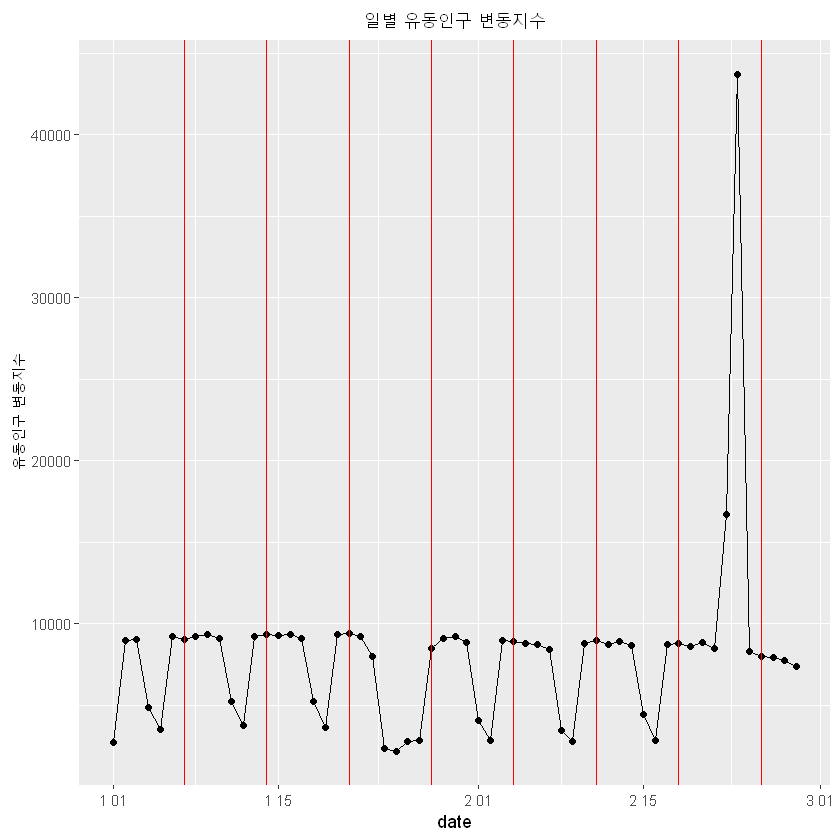

In [12]:
#for traffic variable
sub_df<-seoulfloating %>% 
  group_by(province,city,date,hour) %>%
  summarise(
    population_by_city_hour=sum(fp_num,na.rm=TRUE)
  )
sub_df<-as.data.frame(sub_df)

traffic_diff<-c()
len<-length(sub_df$province)
for(i in 1:len){
  
  traffic_diff[i] <- ifelse(sub_df$city[i] != sub_df$city[i+1],NA,ifelse(i == len, NA,abs(sub_df$population_by_city_hour[i+1] - sub_df$population_by_city_hour[i])))
}

sub_df$traffic_diff<-traffic_diff

#for traffic variable
traffic<-as.data.frame( sub_df %>%
    group_by(province,city,date) %>%
    summarise(
    traffic_by_city=mean(traffic_diff,na.rm=TRUE)) %>%
    group_by(date) %>%
    summarise(
    traffic=mean(traffic_by_city,na.rm=TRUE)))

len<-length(traffic$date)
traffic<-traffic[1:len-1,]

#for traffic variable

ggplot(data =traffic, aes(x=date, y=traffic)) +
  geom_line() + geom_point() +
  ggtitle("일별 유동인구 변동지수") +
  theme(plot.title = element_text(hjust = 0.5)) +
  geom_vline(xintercept = as.Date("2020-01-07") + 7*c(0:10), col="red") +  labs(x = "date", y = "유동인구 변동지수") 

- 유동인구의 변동 즉, 사회적 거리두기의 지표로써 유동인구 변동지수를 개발하게 되었습니다.
- **해당 지표(유동인구 변동지수)**는 지역별로 '일별 평균 유동인구 차이'를 구한 뒤 이것의 평균으로 정의한 것입니다. 

<center>(일별 평균 유동인구 차이 : 유동인구의 1차 차분의 절대값을 일별 평균 한 것)</center>

In [13]:
traffic[traffic$traffic>10000,] #53, 54번째 행은 아웃라이어로 추측됨
traffic[53,dim(traffic)[2]]<-traffic[53-7,dim(traffic)[2]] #주기성 고려 전 주의 유동인구 변동지수로 대체
traffic[54,dim(traffic)[2]]<-traffic[54-7,dim(traffic)[2]] #주기성 고려 전 주의 유동인구 변동지수로 대체
traffic[53:54,]

,date,traffic
53,2020-02-22,16709.00000000000
54,2020-02-23,43728.76666666667


,date,traffic
53,2020-02-22,4431.7333333333336
54,2020-02-23,2836.4499999999998


- 이전 그래프에서 확인했던 2월 23일의 유동인구수와 마찬가지로 위에서 정의한 '유동인구 변동지수'에서도 비정상적임을 확인할 수 있습니다.
- 모델링을 위해서 비슷한 흐름을 보이는 일주일 전의 데이터 값으로 대체하였습니다.

In [14]:
tmp2 = unique(sdata[sdata$date != '2020-02-23',c('date','wday','weekgroup')])
final = right_join(traffic, tmp2)

Joining, by = "date"


Warning message:
"Removed 1 rows containing missing values (geom_bar)."

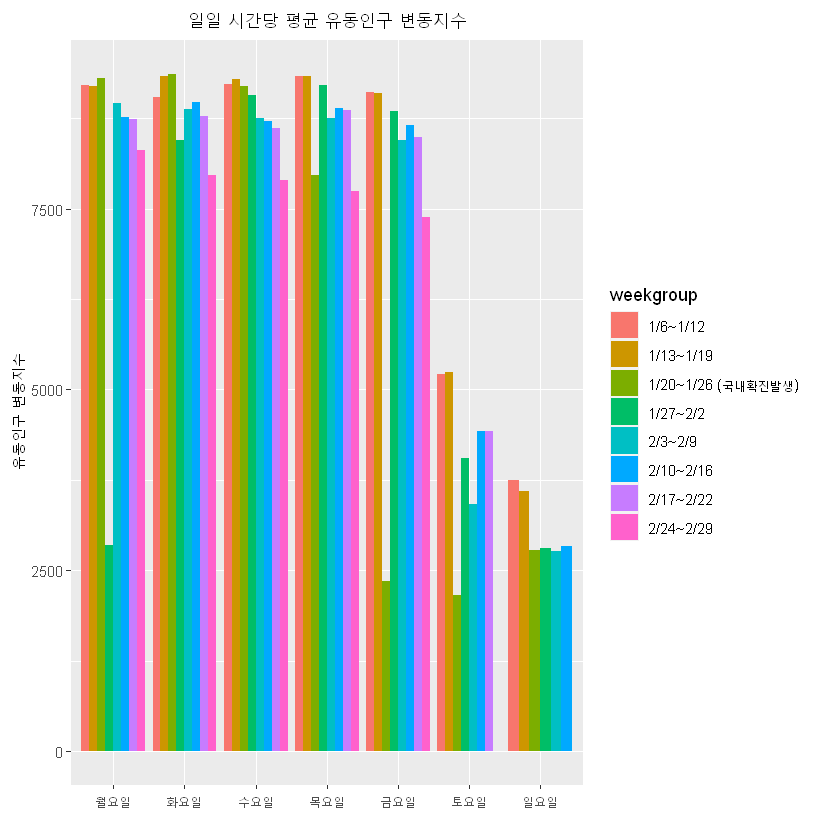

In [15]:
transform(final,weekgroup = factor(weekgroup, levels = c('1/6~1/12','1/13~1/19','1/20~1/26 (국내확진발생)','1/27~2/2','2/3~2/9','2/10~2/16','2/17~2/22','2/24~2/29') ))  %>%
  ggplot(aes(x = wday, y = traffic))+
  geom_bar(aes(fill = weekgroup), 
           stat="identity", 
           position='dodge') +
  scale_x_discrete(limits = c('월요일','화요일','수요일','목요일','금요일','토요일','일요일')) +
labs(x = "", y = "유동인구 변동지수") +
ggtitle("일일 시간당 평균 유동인구 변동지수") + theme(plot.title = element_text(hjust = 0.5))

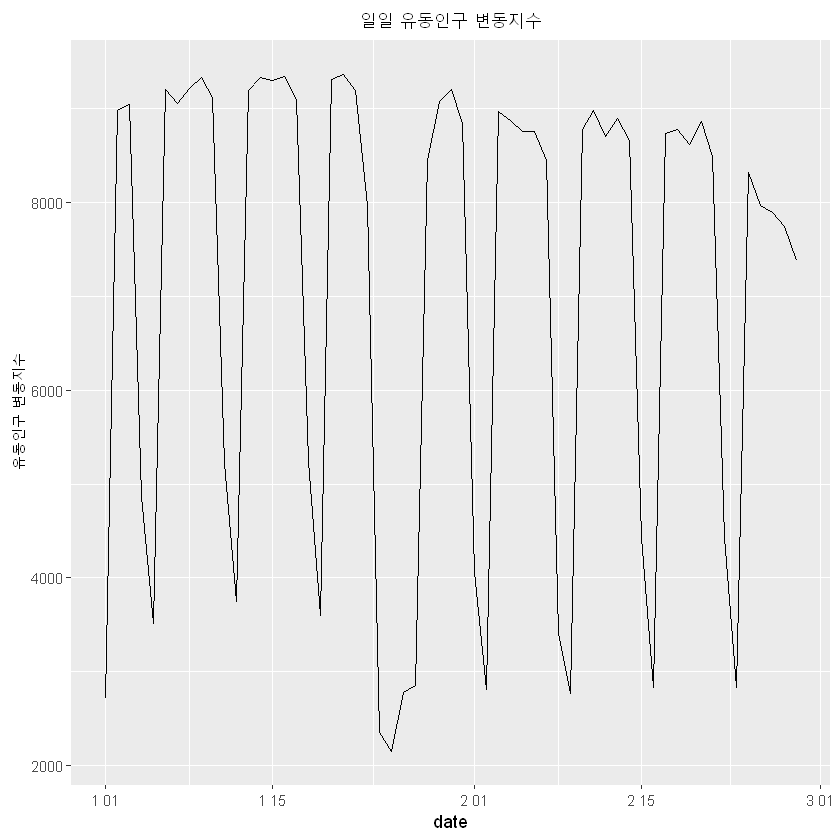

In [16]:
 traffic %>% ggplot(aes(x = date, y = traffic)) + geom_line() + labs(x = "date", y = "유동인구 변동지수") + ggtitle("일일 유동인구 변동지수") + theme(plot.title = element_text(hjust = 0.5))

- 전반적으로 weekgroup에 따른 평균 유동인구수가 줄어드는 것을 확인할 수 있습니다.
- **사회적 거리두기 운동이 자발적으로 잘 지켜지고 있음을 확인할 수 있습니다.**

In [17]:
sub_df<-as.data.frame( sdata[sdata$date != '2020-02-23',] %>% 
  group_by(birth_year,city,date,hour) %>%
  summarise(
    population_by_city_hour=sum(fp_num,na.rm=TRUE)
  ))

len<-dim(sub_df)[1]
for(i in 1:len){
  sub_df$traffic_diff[i] <- ifelse(sub_df$city[i] != sub_df$city[i+1],NA,
                                   ifelse(i == len, NA,
                                          abs(sub_df$population_by_city_hour[i+1] - sub_df$population_by_city_hour[i])))
}

traffic2 <-as.data.frame(sub_df %>%
                         group_by(birth_year,city,date) %>%
                         summarise(
                           traffic_by_city=mean(traffic_diff,na.rm=TRUE)) %>%
                         group_by(birth_year, date) %>%
                         summarise(
                           traffic=mean(traffic_by_city,na.rm=TRUE)))

tmp2 = unique(sdata[sdata$date != '2020-02-23',c('date','wday','weekgroup')])
final = right_join(traffic2, tmp2)

Joining, by = "date"


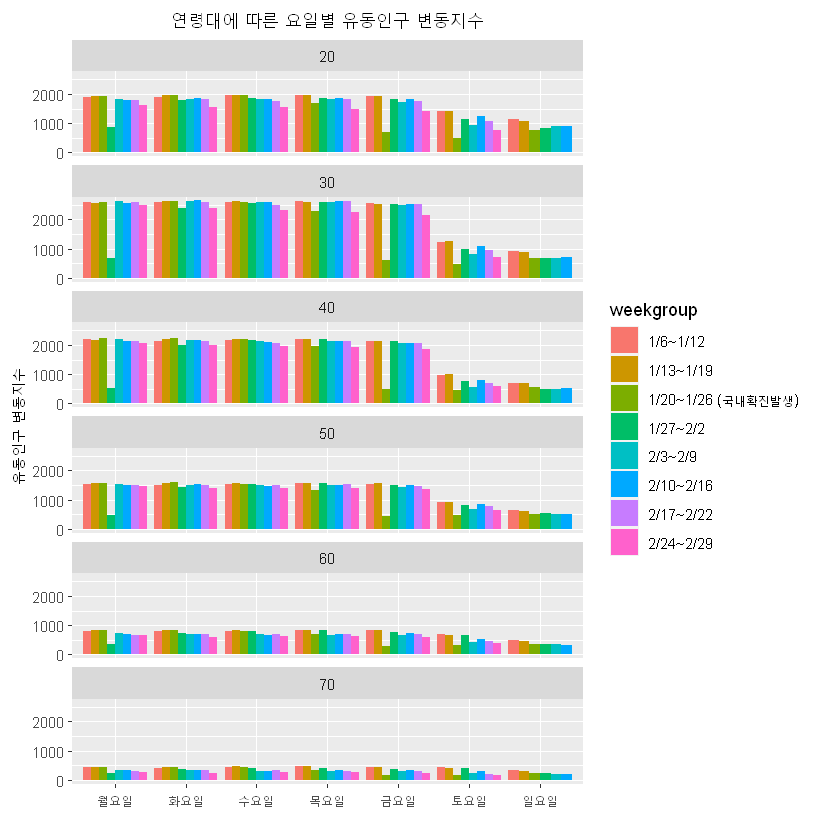

In [18]:
transform(final,weekgroup = factor(weekgroup, levels = c('1/6~1/12','1/13~1/19','1/20~1/26 (국내확진발생)','1/27~2/2','2/3~2/9','2/10~2/16','2/17~2/22','2/24~2/29') ))  %>%
  ggplot(aes(x = wday, y = traffic))+
  geom_bar(aes(fill = weekgroup), 
           stat="identity", 
           position='dodge') +
  scale_x_discrete(limits = c('월요일','화요일','수요일','목요일','금요일','토요일','일요일')) +
labs(x = "", y = "유동인구 변동지수") +
facet_wrap(~ birth_year	, ncol = 1) +
ggtitle("연령대에 따른 요일별 유동인구 변동지수") + theme(plot.title = element_text(hjust = 0.5))

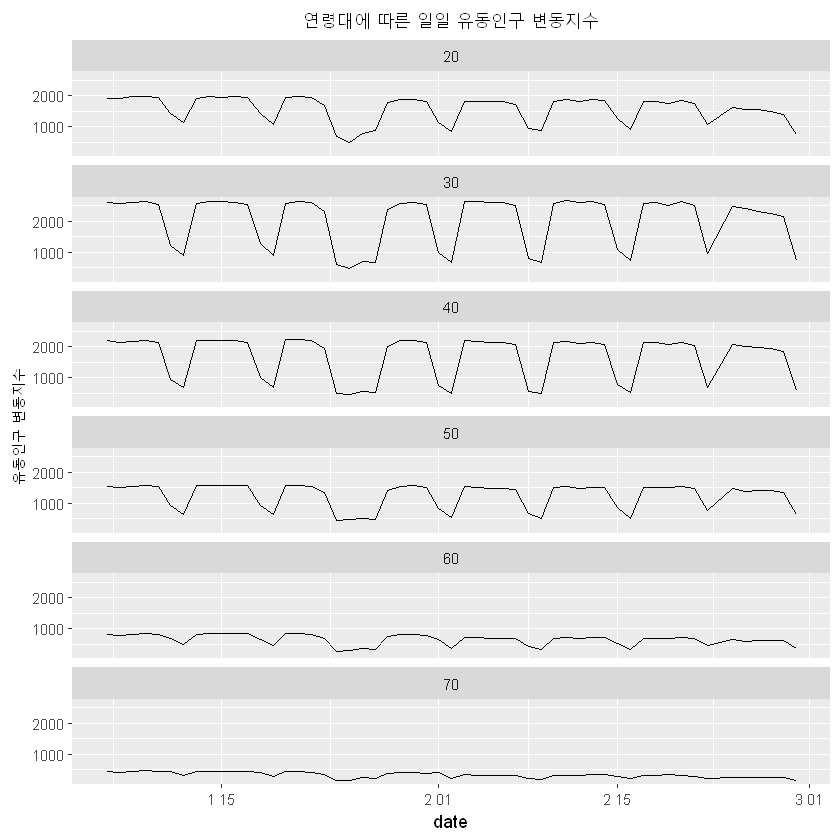

In [19]:
 traffic2 %>% ggplot(aes(x = date, y = traffic)) + geom_line() + labs(x = "date", y = "유동인구 변동지수") +
facet_wrap(~ birth_year	, ncol = 1) +
ggtitle("연령대에 따른 일일 유동인구 변동지수") + theme(plot.title = element_text(hjust = 0.5))

In [20]:
sub_df<-as.data.frame( sdata[sdata$date != '2020-02-23',] %>% 
  group_by(sex,city,date,hour) %>%
  summarise(
    population_by_city_hour=sum(fp_num,na.rm=TRUE)
  ))

len<-dim(sub_df)[1]
for(i in 1:len){
  sub_df$traffic_diff[i] <- ifelse(sub_df$city[i] != sub_df$city[i+1],NA,
                                   ifelse(i == len, NA,
                                          abs(sub_df$population_by_city_hour[i+1] - sub_df$population_by_city_hour[i])))
  
}

traffic3 <-as.data.frame(sub_df %>%
                         group_by(sex,city,date) %>%
                         summarise(
                           traffic_by_city=mean(traffic_diff,na.rm=TRUE)) %>%
                         group_by(sex, date) %>%
                         summarise(
                           traffic=mean(traffic_by_city,na.rm=TRUE)))

tmp2 = unique(sdata[sdata$date != '2020-02-23',c('date','wday','weekgroup')])
final = left_join(traffic3, tmp2)

Joining, by = "date"


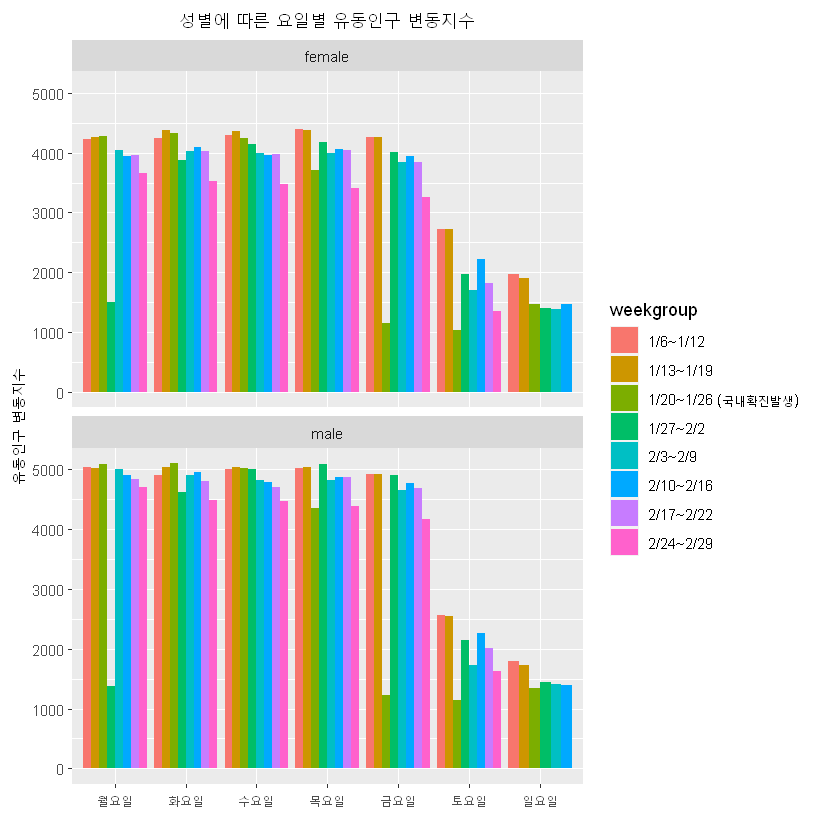

In [21]:
transform(final,weekgroup = factor(weekgroup, levels = c('1/6~1/12','1/13~1/19','1/20~1/26 (국내확진발생)','1/27~2/2','2/3~2/9','2/10~2/16','2/17~2/22','2/24~2/29') ))  %>%
  ggplot(aes(x = wday, y = traffic))+
  geom_bar(aes(fill = weekgroup), 
           stat="identity", 
           position='dodge') +
  scale_x_discrete(limits = c('월요일','화요일','수요일','목요일','금요일','토요일','일요일')) +
labs(x = "", y = "유동인구 변동지수") +
facet_wrap(~ sex, ncol = 1) +
ggtitle("성별에 따른 요일별 유동인구 변동지수") + theme(plot.title = element_text(hjust = 0.5))

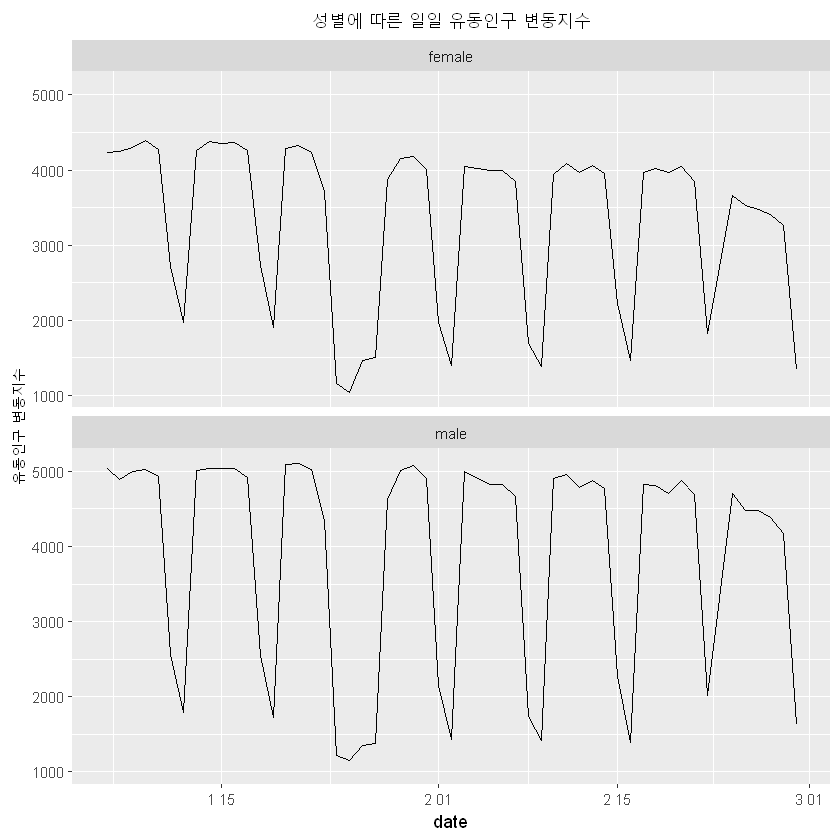

In [22]:
 traffic3 %>% ggplot(aes(x = date, y = traffic)) + geom_line() + labs(x = "date", y = "유동인구 변동지수") +
facet_wrap(~ sex, ncol = 1) + ggtitle("성별에 따른 일일 유동인구 변동지수") + theme(plot.title = element_text(hjust = 0.5))

- 31번 환자(슈퍼 전파자)가 발생한 2월 18일 이후에 성별, 나이에 상관없이 급격히 유동량(유동인구 변동지수)이 줄어듦을 확인할 수 있습니다.
- 이를 통해 사람들이 자발적으로 사회적 거리두기를 시작했음을 알 수 있습니다.

In [23]:
sub_df<-as.data.frame( sdata[sdata$date != '2020-02-23' & 
                             sdata$city %in% c("Jongno-gu", "Gangnam-gu", "Seocho-gu", "Jung-gu"),] %>% 
  group_by(city,date,hour) %>%
  summarise(
    population_by_city_hour=sum(fp_num,na.rm=TRUE)
  ))

len<-dim(sub_df)[1]
for(i in 1:len){
  sub_df$traffic_diff[i] <- ifelse(sub_df$city[i] != sub_df$city[i+1],NA,
                                   ifelse(i == len, NA,
                                          abs(sub_df$population_by_city_hour[i+1] - sub_df$population_by_city_hour[i])))
}

traffic4 <-as.data.frame(sub_df %>%
                         group_by(city, date) %>%
                         summarise(
                           traffic=mean(population_by_city_hour,na.rm=TRUE)))

tmp2 = unique(sdata[sdata$date != '2020-02-23',c('date','wday','weekgroup')])
final = left_join(traffic4, tmp2)

Joining, by = "date"


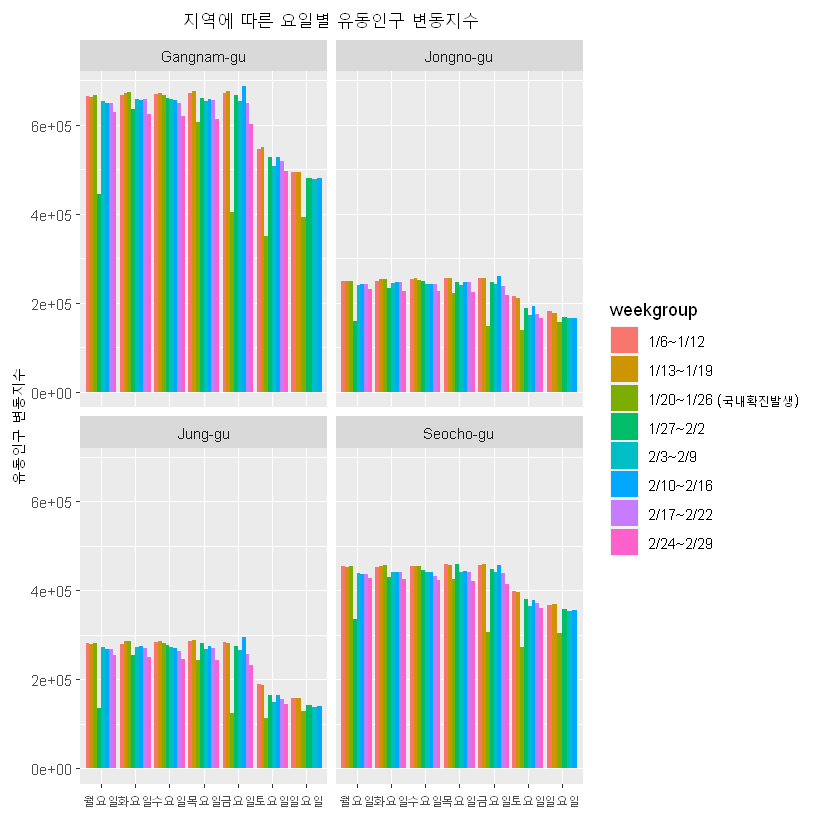

In [24]:
transform(final,weekgroup = factor(weekgroup, levels = c('1/6~1/12','1/13~1/19','1/20~1/26 (국내확진발생)','1/27~2/2','2/3~2/9','2/10~2/16','2/17~2/22','2/24~2/29') ))  %>%
  ggplot(aes(x = wday, y = traffic))+
  geom_bar(aes(fill = weekgroup), 
           stat="identity", 
           position='dodge') +
  scale_x_discrete(limits = c('월요일','화요일','수요일','목요일','금요일','토요일','일요일')) +
labs(x = "", y = "유동인구 변동지수") +
facet_wrap(~ city, ncol = 2) + ggtitle("지역에 따른 요일별 유동인구 변동지수") +
theme(plot.title = element_text(hjust = 0.5))

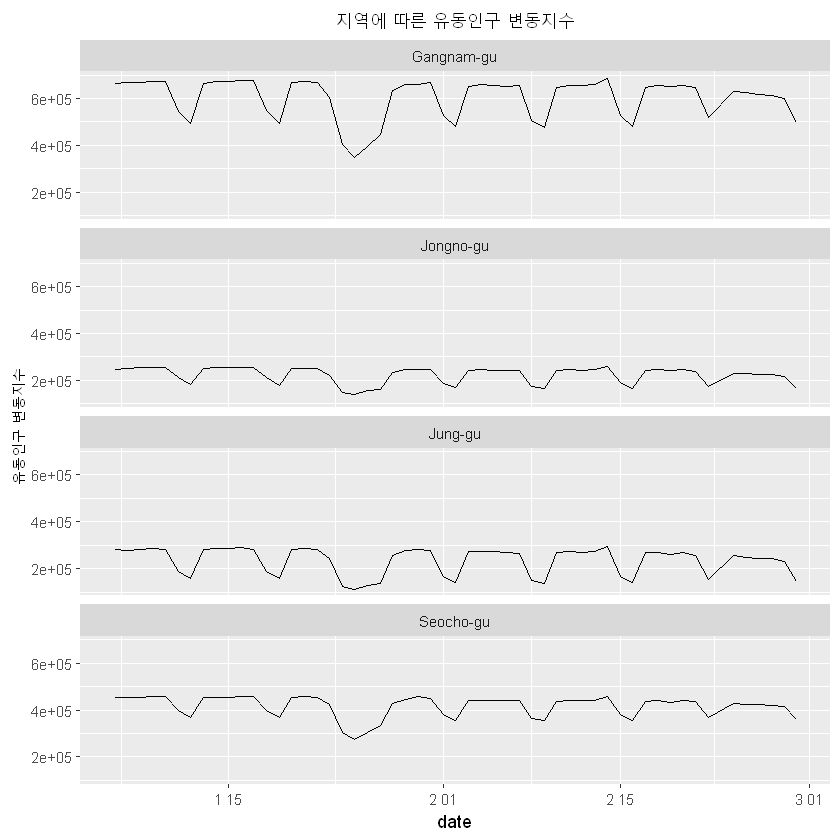

In [25]:
 traffic4 %>% ggplot(aes(x = date, y = traffic)) + geom_line() + labs(x = "date", y = "유동인구 변동지수") +
facet_wrap(~ city, ncol = 1) + ggtitle("지역에 따른 유동인구 변동지수") + theme(plot.title = element_text(hjust = 0.5))

- 산업군이 많아 평일과 주말의 유동인구 차이가 컸던 강남구', '종로구', '중구', '서초구' 4개의 구의 시간에 따른 '유동인구 변동지수'를 확인해보았습니다.
- **전체적인 그래프를 보았을때, 주말의 경우에는 코로나 이전의 시기에 비해 확실히 줄어듦을 육안으로 확인할 수 있습니다.**

### 2.2 모델링(R)

#### 2.2.1 데이터 전처리

- 모델링을 하기 위해서 변수들을 생성합니다. 필요한 변수는 patient(일일 확진자 수), temp(일일 평균 온도), rain(일일 평균 강수량), wind(일일 평균 최대풍속), humidity(일일 평균 상대습도), oversea(일일 해외 유입 확진자 수), national_patient(일일 해외 유입을 제거한 국내 확진자 수), traffic(일일 유동인구 변동지수) 등이 있습니다.   

In [26]:
#for patient variable
patient<-c()
len<-length(time$confirmed)
for(i in 1:len-1){
  patient<-c(patient,time$confirmed[i+1]-time$confirmed[i])
}
patient<-c(1,patient)

In [27]:
#for weather variable

temp<-weather %>% 
  group_by(date) %>%
  summarise(
    temp=mean(avg_temp,na.rm=TRUE)
    #rain=mean(precipitation,na.rm=TRUE)
    #wind=mean(max_wind_speed,na.rm=TRUE)
    #humidity=mean(avg_relative_humidity,na.rm=TRUE)
  )


rain<-weather %>% 
  group_by(date) %>%
  summarise(
    #temp=mean(avg_temp,na.rm=TRUE)
    rain=mean(precipitation,na.rm=TRUE)
    #wind=mean(max_wind_speed,na.rm=TRUE)
    #humidity=mean(avg_relative_humidity,na.rm=TRUE)
  )

wind<-weather %>% 
  group_by(date) %>%
  summarise(
    #temp=mean(avg_temp,na.rm=TRUE)
    #rain=mean(precipitation,na.rm=TRUE)
    wind=mean(max_wind_speed,na.rm=TRUE)
    #humidity=mean(avg_relative_humidity,na.rm=TRUE)
  )

humidity<-weather %>% 
  group_by(date) %>%
  summarise(
    #temp=mean(avg_temp,na.rm=TRUE)
    #rain=mean(precipitation,na.rm=TRUE)
    #wind=mean(max_wind_speed,na.rm=TRUE)
    humidity=mean(avg_relative_humidity,na.rm=TRUE)
  )

In [28]:
#for oversea variable

sub_df2<-subset(patientinfo, infection_case=="overseas inflow")
sub_df2<-sub_df2 %>%
  group_by(confirmed_date) %>%
  summarise(
    oversea=n()
  )
colnames(sub_df2)<-c("date","oversea")
head(sub_df2)

date,oversea
2020-01-20,1
2020-01-23,1
2020-01-26,1
2020-01-27,1
2020-01-30,2
2020-01-31,1


In [29]:
#data aggregating

time$patient <- patient
traffic$date<-as.character(traffic$date)
time<-left_join(time,traffic,by="date")

left_df<-time[,c("date","patient","traffic")]
total_df<-left_join(left_df,temp,by="date")
total_df<-left_join(total_df,rain,by="date")
total_df<-left_join(total_df,wind,by="date")
total_df<-left_join(total_df,humidity,by="date")
total_df<-left_join(total_df,sub_df2,by="date")
head(total_df)
tail(total_df)

date,patient,traffic,temp,rain,wind,humidity,oversea
2020-01-20,1,9308.7999999999993,3.4750000000000001,0.00000000000000000,6.0312500000000000,53.274999999999999,1
2020-01-21,0,9365.7500000000000,1.8937500000000000,0.00000000000000000,4.2687499999999998,47.962499999999999,NA
2020-01-22,0,9190.7500000000000,4.4812500000000002,5.96250000000000036,3.8874999999999997,67.637500000000003,NA
2020-01-23,0,7967.3000000000002,6.3125000000000000,2.06250000000000000,4.2562499999999996,77.181249999999991,1
2020-01-24,1,2349.6500000000001,5.6250000000000000,1.38749999999999996,4.1500000000000004,70.700000000000003,NA
2020-01-25,0,2150.8666666666668,6.0875000000000004,0.22500000000000001,3.4187500000000002,74.581249999999997,NA


,date,patient,traffic,temp,rain,wind,humidity,oversea
80,2020-04-08,53,NA,10.6187500000000004,0.2562499999999999778,6.7437500000000004,43.524999999999999,16
81,2020-04-09,39,NA,9.6562500000000000,0.0000000000000000000,5.7999999999999998,49.887500000000003,8
82,2020-04-10,27,NA,10.0374999999999996,0.0062500000000000003,4.4500000000000002,58.737499999999997,6
83,2020-04-11,30,NA,9.5500000000000007,3.0124999999999997335,4.6437499999999998,69.362499999999997,2
84,2020-04-12,32,NA,9.0562500000000004,5.5125000000000001776,7.3125000000000000,72.037499999999994,12
85,2020-04-13,25,NA,NA,NA,NA,NA,1


In [30]:
#for national patient variable

total_df_r<-total_df[complete.cases(total_df$traffic),] #traffic 있는 날짜까지로 데이터프레임 교체
total_df_r[!complete.cases(total_df_r),"oversea"]<-0 #NA를 0로 교체
sum(total_df_r[,'patient']<total_df_r[,'oversea']) #총 환자수 보다 해외 유입 환자수가 많은 경우가 두건 발생. 이는 검사시간의 차이에 따른 오류로 보임
total_df_r[total_df_r[,'patient']<total_df_r[,'oversea'],]

total_df_r$national_patient <- total_df_r[,"patient"]-total_df_r[,"oversea"]
head(total_df_r,20) #national_patient에 음수값 존재.
total_df_r[c(4,5,15,16),"national_patient"]<-0 #검사 시차문제 해결
head(total_df_r,20)


[1] 2

,date,patient,traffic,temp,rain,wind,humidity,oversea
4,2020-01-23,0,7967.3000000000002,6.3125000000000000,2.0625000000000000000,4.2562499999999996,77.181249999999991,1
15,2020-02-03,0,8965.0833333333339,2.4562499999999998,0.0062500000000000003,5.6250000000000000,52.225000000000001,1


date,patient,traffic,temp,rain,wind,humidity,oversea,national_patient
2020-01-20,1,9308.7999999999993,3.4750000000000001,0.0000000000000000000,6.0312500000000000,53.274999999999999,1,0
2020-01-21,0,9365.7500000000000,1.8937500000000000,0.0000000000000000000,4.2687499999999998,47.962499999999999,0,0
2020-01-22,0,9190.7500000000000,4.4812500000000002,5.9625000000000003553,3.8874999999999997,67.637500000000003,0,0
2020-01-23,0,7967.3000000000002,6.3125000000000000,2.0625000000000000000,4.2562499999999996,77.181249999999991,1,-1
2020-01-24,1,2349.6500000000001,5.6250000000000000,1.3874999999999999556,4.1500000000000004,70.700000000000003,0,1
2020-01-25,0,2150.8666666666668,6.0875000000000004,0.2250000000000000056,3.4187500000000002,74.581249999999997,0,0
2020-01-26,1,2783.7500000000000,7.0499999999999998,1.2687500000000000444,6.0625000000000000,69.387500000000003,1,0
2020-01-27,1,2850.5000000000000,6.4375000000000000,24.2562499999999978684,7.3187499999999996,77.299999999999997,1,0
2020-01-28,0,8447.0000000000000,7.3750000000000000,1.0874999999999999112,4.8250000000000002,71.112499999999997,0,0
2020-01-29,0,9074.9666666666672,6.6250000000000000,0.3500000000000000333,4.2687499999999998,68.018749999999997,0,0


date,patient,traffic,temp,rain,wind,humidity,oversea,national_patient
2020-01-20,1,9308.7999999999993,3.4750000000000001,0.0000000000000000000,6.0312500000000000,53.274999999999999,1,0
2020-01-21,0,9365.7500000000000,1.8937500000000000,0.0000000000000000000,4.2687499999999998,47.962499999999999,0,0
2020-01-22,0,9190.7500000000000,4.4812500000000002,5.9625000000000003553,3.8874999999999997,67.637500000000003,0,0
2020-01-23,0,7967.3000000000002,6.3125000000000000,2.0625000000000000000,4.2562499999999996,77.181249999999991,1,0
2020-01-24,1,2349.6500000000001,5.6250000000000000,1.3874999999999999556,4.1500000000000004,70.700000000000003,0,0
2020-01-25,0,2150.8666666666668,6.0875000000000004,0.2250000000000000056,3.4187500000000002,74.581249999999997,0,0
2020-01-26,1,2783.7500000000000,7.0499999999999998,1.2687500000000000444,6.0625000000000000,69.387500000000003,1,0
2020-01-27,1,2850.5000000000000,6.4375000000000000,24.2562499999999978684,7.3187499999999996,77.299999999999997,1,0
2020-01-28,0,8447.0000000000000,7.3750000000000000,1.0874999999999999112,4.8250000000000002,71.112499999999997,0,0
2020-01-29,0,9074.9666666666672,6.6250000000000000,0.3500000000000000333,4.2687499999999998,68.018749999999997,0,0


- 위의 작업은 반응변수로 쓸 national_patient 변수를 만드는 과정이었습니다. patient 변수에서 oversea 변수를 뺀 값은 일일 국내 확진자 수, 즉 national_patient 변수가 됩니다. 다만, 이 경우에 1월 23일과 2월 3일에 national_patient 값이 -1이 되는데 이는 확진자수 카운트 시간 기준이 다름에 기인한 것으로 보입니다. 즉, patient는 16시 기준으로 확진자수를 세고 있으며, oversea는 00시 기준으로 확진자수를 세고 있습니다. 따라서 patient 값이 0일때, oversea 값이 1인 경우는 사실 그 날 하루동안 patient는 1임을 알 수 있습니다. 즉 그날 하루동안의 확진자가 16시 이후에 발생하여 다음날로 넘어가 세어진 것입니다. 
- 이를 감안하여, 1월 22일, 1월 23일, 2월 3일, 2월 4일의 national_patient를 0으로 수정하였습니다. 이후 모델링에서는 반응변수를 national_patient로 할것입니다. 국내 유동량과 날씨는 국내의 확진자수에 영향을 주는게 타당하다고 판단하였기 때문입니다.

In [31]:
real_mean<-mean(total_df_r$traffic)
real_sd<-sd(total_df_r$traffic)
print(real_mean)
print(real_sd)

[1] 6992.3945833333337
[1] 2615.5331915096608


- 유동인구 변동지수의 평균과 표준편차가 뒤에서 쓰일것이므로 미리 저장해둡니다.

In [32]:
#설명변수 표준화
scale_function<-function(x){
    y<-(x-mean(x))/sd(x)
    return(y)
}

len<-dim(total_df_r)[2]
for(i in 3:7){
    total_df_r[,i]<-scale_function(total_df_r[,i])
}

#회귀분석 시행
fit<-lm(national_patient~traffic+temp+rain+wind+humidity,data=total_df_r)
summary(fit) #별로 유의한게 없음. lag 반영 고려
durbinWatsonTest(fit) #예상한대로 심각한 자기상관이 보임.


Call:
lm(formula = national_patient ~ traffic + temp + rain + wind + 
    humidity, data = total_df_r)

Residuals:
                  Min                    1Q                Median 
-124.3135074138557314  -62.9238713472465818  -33.5565304755896250 
                   3Q                   Max 
  -2.4589168474900411  487.2056110198894885 

Coefficients:
                        Estimate           Std. Error              t value
(Intercept)  57.8499999999999872  21.7807851609500283  2.65601000000000020
traffic       8.0343480159792602  23.6402986266890913  0.33986000000000000
temp         24.8640744109857259  32.1510901354022991  0.77334999999999998
rain        -13.5056504280640723  29.0663530364393843 -0.46465000000000001
wind          7.7369240130931631  27.7845715837548433  0.27845999999999999
humidity     19.5741033895549954  34.5976806441686691  0.56576000000000004
            Pr(>|t|)  
(Intercept) 0.011951 *
traffic     0.736054  
temp        0.444659  
rain        0.645145  
wind 

 lag     Autocorrelation       D-W Statistic p-value
   1 0.71360543087334261 0.20110620209928126       0
 Alternative hypothesis: rho != 0

- 설명변수의 스케일이 너무 다양하므로, 표준화합니다. 그리고 이를 이용하여 회귀분석을 해보았습니다. 
- 그 결과 적합된 회귀모형은 유의하게 나오지 않았고 반응변수들간의 자기상관을 검사하는 더빈왓슨 테스트 결과 유의하게 나와서, 자기상관이 심하게 존재함을 확인할 수 있었습니다. 
- 현실적으로 당일 확진자수는 과거의 날씨와 유동량에 의존할것이므로 설명변수에 lag(시차)를 두는것이 타당해보입니다.

In [33]:
#lag 만드는 과정
total_df_rr<-total_df_r[,c("traffic","temp","rain","wind","humidity","national_patient")]

make_lag<-function(x,y){
  len<-length(x)
  vec<-c(rep(NA,y),x)
  vec<-vec[1:len]
  return(vec)
}

total_df_rrr<-total_df_rr #for dataframe of lag variables
for(i in 1 : dim(total_df_rr)[2]){
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],1))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag1")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],2))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag2")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],3))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag3")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],4))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag4")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],5))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag5")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],6))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag6")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],7))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag7")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],8))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag8")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],9))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag9")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],10))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag10")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],11))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag11")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],12))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag12")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],13))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag13")
  
  total_df_rrr<-cbind(total_df_rrr,make_lag(total_df_rr[,i],14))
  colnames(total_df_rrr)[dim(total_df_rrr)[2]]<-paste0(colnames(total_df_rr)[i],"_lag14")
}

head(total_df_rrr)
tail(total_df_rrr)

traffic,temp,rain,wind,humidity,national_patient,traffic_lag1,traffic_lag2,traffic_lag3,traffic_lag4,...,national_patient_lag5,national_patient_lag6,national_patient_lag7,national_patient_lag8,national_patient_lag9,national_patient_lag10,national_patient_lag11,national_patient_lag12,national_patient_lag13,national_patient_lag14
0.88563411245783441,-0.383047027199544032,-0.403574756936909640,0.76610816695666717,-0.89222436350099543,0,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
0.90740787552261504,-0.853716759503986400,-0.403574756936909640,-0.63904632463214694,-1.32273680047638509,0,0.88563411245783441,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
0.84049991175902328,-0.083529924823989854,0.581484263448946326,-0.94299818274178404,0.27167867199246987,0,0.90740787552261504,0.88563411245783441,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
0.37273677880721534,0.461553994406055879,-0.062831070639915457,-0.64901195932426625,1.04508160288825702,0,0.84049991175902328,0.90740787552261504,0.88563411245783441,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-1.77506620768730716,0.256914980360646195,-0.174347186155295375,-0.73371985420727936,0.51985642977828272,0,0.37273677880721534,0.84049991175902328,0.90740787552261504,0.88563411245783441,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-1.85106728233572260,0.394581226173012778,-0.366402718431782959,-1.31670948369625540,0.83438375138030219,0,-1.77506620768730716,0.37273677880721534,0.84049991175902328,0.90740787552261504,...,0,NA,NA,NA,NA,NA,NA,NA,NA,NA


,traffic,temp,rain,wind,humidity,national_patient,traffic_lag1,traffic_lag2,traffic_lag3,traffic_lag4,...,national_patient_lag5,national_patient_lag6,national_patient_lag7,national_patient_lag8,national_patient_lag9,national_patient_lag10,national_patient_lag11,national_patient_lag12,national_patient_lag13,national_patient_lag14
35,-1.58894736905807044,-0.11887666361365162,-0.403574756936909640,0.277792067042824165,-1.16825880838521590,167,-0.97902074357619251,0.57207153332651783,0.71569425668533693,0.62037908316383117,...,1,1,1,0,0,0,0,1,0,2
36,0.50531012986450330,1.09593493794682573,-0.375695728058064615,-0.688874498092743148,-0.98440467353572614,231,-1.58894736905807044,-0.97902074357619251,0.57207153332651783,0.71569425668533693,...,20,1,1,1,0,0,0,0,1,0
37,0.37394749434198488,1.08105210056170531,4.219181253825644795,0.616623646574878448,2.05298719063064095,142,0.50531012986450330,-1.58894736905807044,-0.97902074357619251,0.57207153332651783,...,53,20,1,1,1,0,0,0,0,1
38,0.34596722111475364,0.83920599305349364,-0.076254306766766713,0.033634017085902322,1.17322236354093268,283,0.37394749434198488,0.50531012986450330,-1.58894736905807044,-0.97902074357619251,...,100,53,20,1,1,1,0,0,0,0
39,0.28504911315475934,0.40388299953871326,-0.370532944932352615,-0.484578986904298126,0.35018388108798210,502,0.34596722111475364,0.37394749434198488,0.50531012986450330,-1.58894736905807044,...,228,100,53,20,1,1,1,0,0,0
40,0.14955730043997342,0.21970788689784443,0.048685044875464434,-1.102448337815691737,1.45432166062486368,571,0.28504911315475934,0.34596722111475364,0.37394749434198488,0.50531012986450330,...,167,228,100,53,20,1,1,1,0,0


In [34]:
total_df_rrrr<-na.omit(total_df_rrr) #위에있는 14개의 행 제거 (NA 존재...)
head(total_df_rrrr)

,traffic,temp,rain,wind,humidity,national_patient,traffic_lag1,traffic_lag2,traffic_lag3,traffic_lag4,...,national_patient_lag5,national_patient_lag6,national_patient_lag7,national_patient_lag8,national_patient_lag9,national_patient_lag10,national_patient_lag11,national_patient_lag12,national_patient_lag13,national_patient_lag14
15,0.75422049943911551,-0.68628483892137848,-0.40254220031176718,0.442225039462791625,-0.97731388045613110,0,-1.59883063113400681,-1.12298756503436681,0.70809860975141303,0.84536826264620279,...,0,0,0,0,0,0,0,0,0,0
16,0.71975971200735323,-0.94673449316099079,-0.34368647267865010,0.093427825238617951,-1.04011804773254068,0,0.75422049943911551,-1.59883063113400681,-1.12298756503436681,0.70809860975141303,...,0,0,0,0,0,0,0,0,0,0
17,0.67280306581936167,-2.23596028164707183,-0.39015152081005838,1.184664824025675856,-1.85961113364569441,0,0.71975971200735323,0.75422049943911551,-1.59883063113400681,-1.12298756503436681,...,4,0,0,0,0,0,0,0,0,0
18,0.67178988808237028,-2.28246914847557392,-0.40357475693690964,-0.230455302255257594,-1.51114930230561395,4,0.67280306581936167,0.71975971200735323,0.75422049943911551,-1.59883063113400681,...,1,4,0,0,0,0,0,0,0,0
19,0.55476467336633550,-1.08626109364649737,-0.40357475693690964,-0.095919233911647625,-1.12925944644744503,0,0.67178988808237028,0.67280306581936167,0.71975971200735323,0.75422049943911551,...,2,1,4,0,0,0,0,0,0,0
20,-1.36864811922617546,-0.74581618846186115,-0.38705385093463113,0.935523956722694727,-0.92717184367899752,0,0.55476467336633550,0.67178988808237028,0.67280306581936167,0.71975971200735323,...,0,2,1,4,0,0,0,0,0,0


In [35]:
len<-length(colnames(total_df_rrrr))-14 #for only national_patient_lag1 and after cochran and orcutt method
col_list<-colnames(total_df_rrrr)[1:len]
total_df_rrrr<-total_df_rrrr[,col_list]
total_df_rrrr<-total_df_rrrr[,-c(1:5)] #현실적으로 과거의 값이 당일 확진자수에 영향을 줄것.

- 코로나 바이러스의 잠복기간이 14일임을 감안하여 설명변수의 lag를 14까지 두었습니다. 
- 현실적으로 당일의 확진자수에 당일의 날씨와 유동량이 영향을 주기는 어렵다고 판단하여(잠복기간 때문에), 이를 제거하였습니다. lag를 14까지 두면서 상위 14개의 행에 NA가 생기므로, 모델링을 위해 이를 제거합니다.
- 모델링에 사용될 national_patient에 대한 시계열 플롯은 아래 그림과 같습니다. 

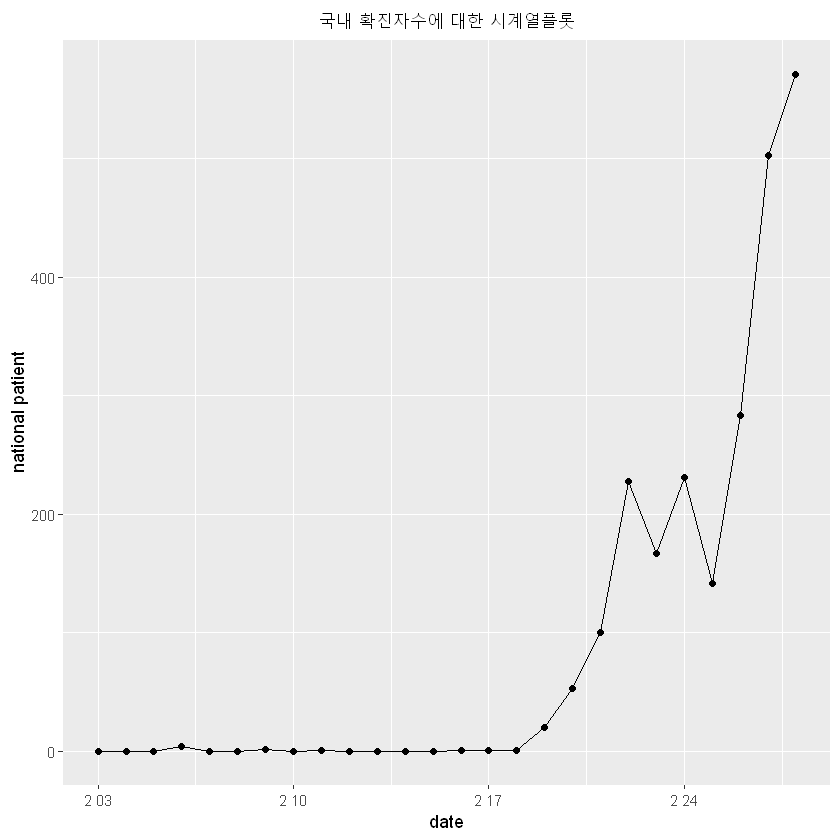

In [36]:
tmp0 <- total_df_rrrr
tmp0$date <- as.Date(total_df_r$date[-c(1:14)])

ggplot(data =tmp0, aes(x=date, y=national_patient)) +
  geom_line() + geom_point() + labs(x="date", y="national patient")+ggtitle("국내 확진자수에 대한 시계열플롯") + theme(plot.title = element_text(hjust = 0.5))

In [37]:
dim(total_df_rrrr)

[1] 26 71

- 모델에 사용할 데이터의 설명변수는 70개, 관측치는 26개로 고차원 문제가 됩니다. 즉, rank의 문제로 인해 회귀분석을 적합할 수 없게 됩니다. 따라서 변수선택을 시행해야 합니다. 변수선택은 F-test 기반으로 전진선택법을 사용하였습니다.

#### 2.2.2 변수 선택

In [38]:
#variable selection
library(gdata)
len<-dim(total_df_rrrr)[2]
f<-paste0(colnames(total_df_rrrr[2:len]),collapse="+")
f<-paste("~",f,sep="")
f<-as.formula(f)
lm.null<-lm(national_patient~1,data=total_df_rrrr)

library(gdata)

lm.null<-lm(national_patient~1,data=total_df_rrrr)
df1<-add1(lm.null, scope = f, test = "F")
df1<-as.data.frame(df1)
colnames(df1)[6]<-"P_value"


f2<-paste0("~ . ", "+", rownames(df1[which.min(df1$P_value),]))
f2<-as.formula(f2)

df1<-add1(update(lm.null, f2), scope = f, test = "F")
df1<-as.data.frame(df1)
colnames(df1)[6]<-"P_value"

f3<-paste0(f2,collapase="")

selected_variable<-c()

for(i in 1:50){

    if(df1$P_value[which.min(df1$P_value)]<=0.05){
    selected_variable<-c(selected_variable,rownames(df1[which.min(df1$P_value),]))
        
    f3<-paste0(f3,"+", rownames(df1[which.min(df1$P_value),]))
    f3<-as.formula(f3)
    
    df1<-add1(update(lm.null, f3), scope = f, test = "F")
    df1<-as.data.frame(df1)
    colnames(df1)[6]<-"P_value"
    print(rownames(df1[which.min(df1$P_value),]))
    
    f3<-paste0(f3,collapse="")
        }
}

length(selected_variable)


[1] "temp_lag13"
[1] "humidity_lag6"
[1] "humidity_lag13"
[1] "temp_lag1"
[1] "rain_lag3"
[1] "rain_lag2"
[1] "temp_lag2"
[1] "traffic_lag12"
[1] "temp_lag7"
[1] "temp_lag4"


[1] 10

- 변수선택의 결과 10개의 변수가 선택되었습니다. 
- 선택된 변수로는 2일전, 6일전, 13일전 습도, 1일전, 2일전, 7일전, 13일전 기온, 2일전, 3일전 강수량, 12일전 유동량(유동인구 변동지수)이 있습니다.

#### 2.2.3 모델링

national_patient ~ humidity_lag2 + temp_lag13 + humidity_lag6 + 
    humidity_lag13 + temp_lag1 + rain_lag3 + rain_lag2 + temp_lag2 + 
    traffic_lag12 + temp_lag7



Call:
lm(formula = f, data = total_df_rrrr)

Residuals:
                Min                  1Q              Median                  3Q 
-90.574128628324658 -10.217460125663564   3.027293638625927  16.609260370940355 
                Max 
 38.312390032309182 

Coefficients:
                            Estimate            Std. Error             t value
(Intercept)      98.2825214576449184    7.9547984419163216 12.3551199999999994
humidity_lag2  -177.8723824933229878   25.6999683882813095 -6.9211099999999997
temp_lag13       74.3081459065064678   19.9962115915761274  3.7161100000000000
humidity_lag6    43.7782175056952241   16.6092891629974524  2.6357699999999999
humidity_lag13  -66.2293281069260189   14.2975754185457369 -4.6322099999999997
temp_lag1        18.0579725478713975    9.0463588537073427  1.9961599999999999
rain_lag3       126.1540023945294422   13.1580298473286881  9.5876099999999997
rain_lag2       159.4897645300364957   19.0528904275813957  8.3709000000000007
temp_lag2    

humidity_lag2          temp_lag13       humidity_lag6      humidity_lag13 
16.5567948065544002  8.9392068931710167  5.2105384450673666  4.3858518852087851 
          temp_lag1           rain_lag3           rain_lag2           temp_lag2 
 2.5054888246566414  3.6743607014363722  7.6650658568532375  6.7877611897629553 
      traffic_lag12           temp_lag7 
 1.4972704916707567  3.6795538870940190


	Durbin-Watson test

data:  model
DW = 2.6386705397155223, p-value = 0.66220073903810173
alternative hypothesis: true autocorrelation is greater than 0


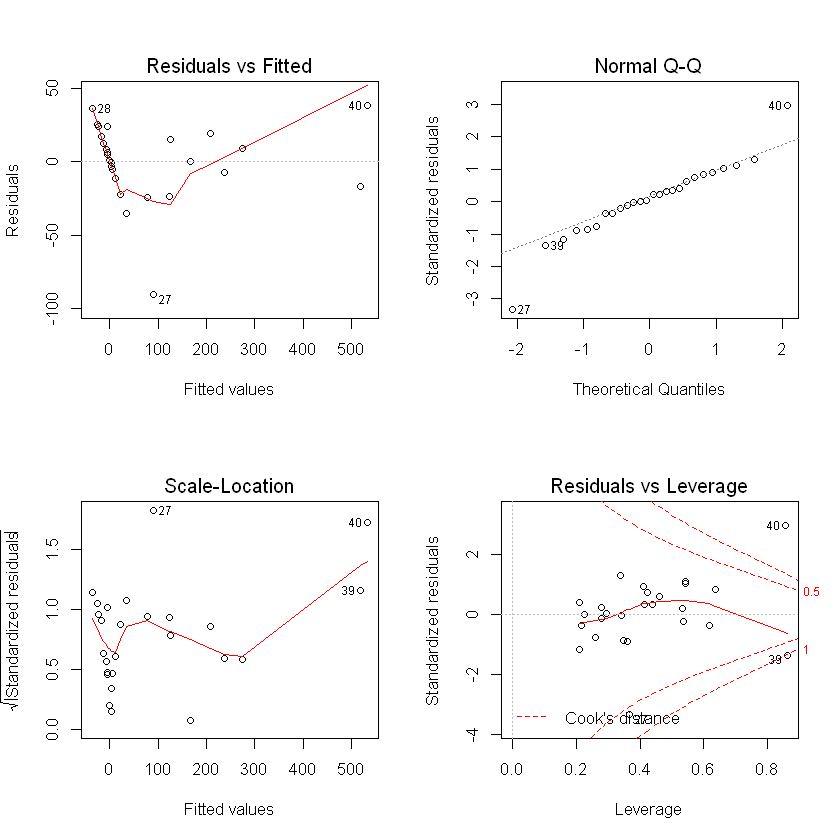

In [39]:
#modeling for selected variables
outcome<-"national_patient"
variables<-selected_variable

f <- as.formula(
  paste(outcome, 
        paste(variables, collapse = " + "), 
        sep = " ~ "))
print(f)

model <- lm(f, data = total_df_rrrr)
summary(model)
par(mfrow=c(2,2))
plot(model) #정규성 문제
vif(model) #다중공선성 없음
dwtest(model) #자기상관은 없음

- 10개의 선택된 변수를 설명변수로 사용하여 다중회귀분석을 시행하였습니다. 
- 그 결과, 12일전 유동량(유동인구 변동지수)이 당일날 국내 확진자수에 유의하게 영향을 줌을 확인할 수 있었습니다.(p-value : 0.0019)
- 더빈왓슨 테스트의 결과로 양의 자기상관이 없음을 확인하였습니다.(p-value : 0.6622)
- VIF의 결과를 보았을때 다중공선성이 심하지 않음을 확인할 수 있었습니다.
- 다만, 잔차그림에서 정규성이 다소 문제가 있음을 확인할 수 있었습니다. 이에 반응변수를 log 변환 하였습니다.

national_patient ~ humidity_lag2 + temp_lag13 + humidity_lag6 + 
    humidity_lag13 + temp_lag1 + rain_lag3 + rain_lag2 + temp_lag2 + 
    traffic_lag12 + temp_lag7



Call:
lm(formula = f, data = total_df_rrrr)

Residuals:
                   Min                     1Q                 Median 
-1.7435566709232637184 -0.7925780503542687594 -0.0045589979206517653 
                    3Q                    Max 
 0.6163333233607893868  1.8832693340812964866 

Coefficients:
                           Estimate           Std. Error              t value
(Intercept)     2.21324339433780093  0.28129992616251587  7.86791000000000018
humidity_lag2  -4.18673640245705769  0.90880985392521807 -4.60683000000000042
temp_lag13      0.55618364639851625  0.70711192562728908  0.78656000000000004
humidity_lag6   1.10385603696018464  0.58734257684567071  1.87941000000000003
humidity_lag13 -1.32677897651977461  0.50559507433239692 -2.62419000000000002
temp_lag1       0.63278595266031701  0.31990000704209748  1.97806999999999999
rain_lag3       2.07199114842534193  0.46529812810770338  4.45303999999999967
rain_lag2       2.88101075345549873  0.67375392470283924  4.2760600000

humidity_lag2          temp_lag13       humidity_lag6      humidity_lag13 
16.5567948065544144  8.9392068931709758  5.2105384450673577  4.3858518852087771 
          temp_lag1           rain_lag3           rain_lag2           temp_lag2 
 2.5054888246566414  3.6743607014363691  7.6650658568532108  6.7877611897629668 
      traffic_lag12           temp_lag7 
 1.4972704916707567  3.6795538870940221


	Durbin-Watson test

data:  model
DW = 2.2786153049019426, p-value = 0.28375617229242484
alternative hypothesis: true autocorrelation is greater than 0


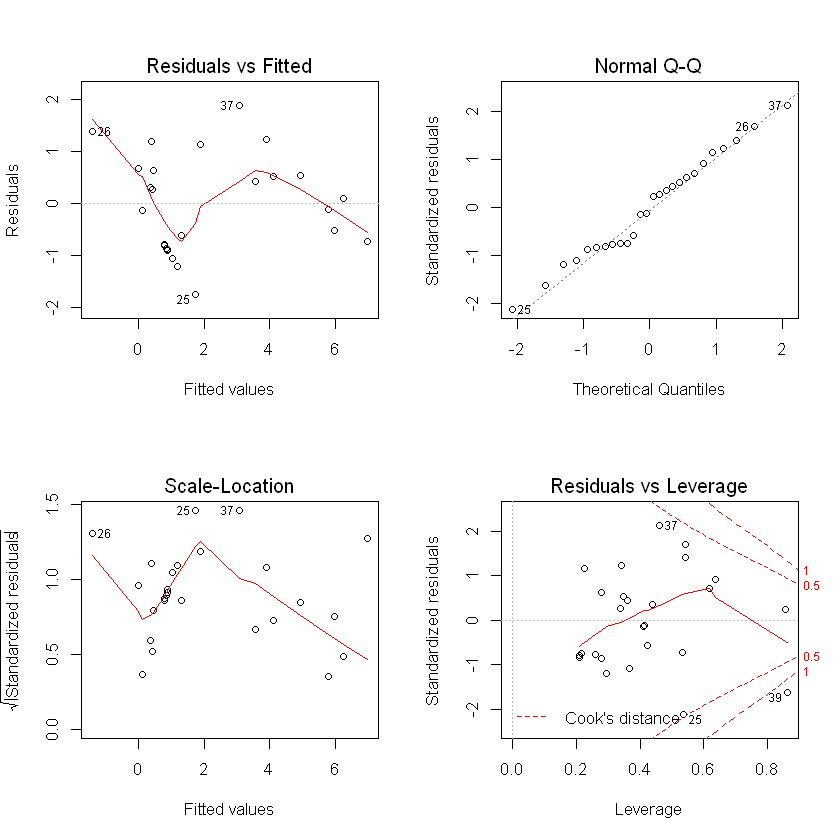

In [40]:
#log transformation
total_df_rrrr$national_patient<-log(total_df_rrrr$national_patient+1) 

outcome<-"national_patient"
variables<-selected_variable

f <- as.formula(
  paste(outcome, 
        paste(variables, collapse = " + "), 
        sep = " ~ "))
print(f)

model <- lm(f, data = total_df_rrrr)
summary(model)
par(mfrow=c(2,2))
plot(model) #정규성 만족
vif(model) 
dwtest(model) #자기상관 없음

- 로그변환 후 회귀분석 결과입니다.
- 잔차그림을 보았을때, 정규성을 만족함을 확인할수 있습니다. 또한 더빈왓슨 테스트 결과 자기상관이 존재하지 않으며, VIF의 결과로 보았을때, 다중공선성 또한 심하지 않으므로, 이를 최종모델로 채택하였습니다.

In [41]:
traffic_effect_ft<-function(x){
    exp(2.2132+0.6379*x)-1
}

li<-seq(-2,2,0.1)
tmp <- data.frame(y = traffic_effect_ft(li), x=li)

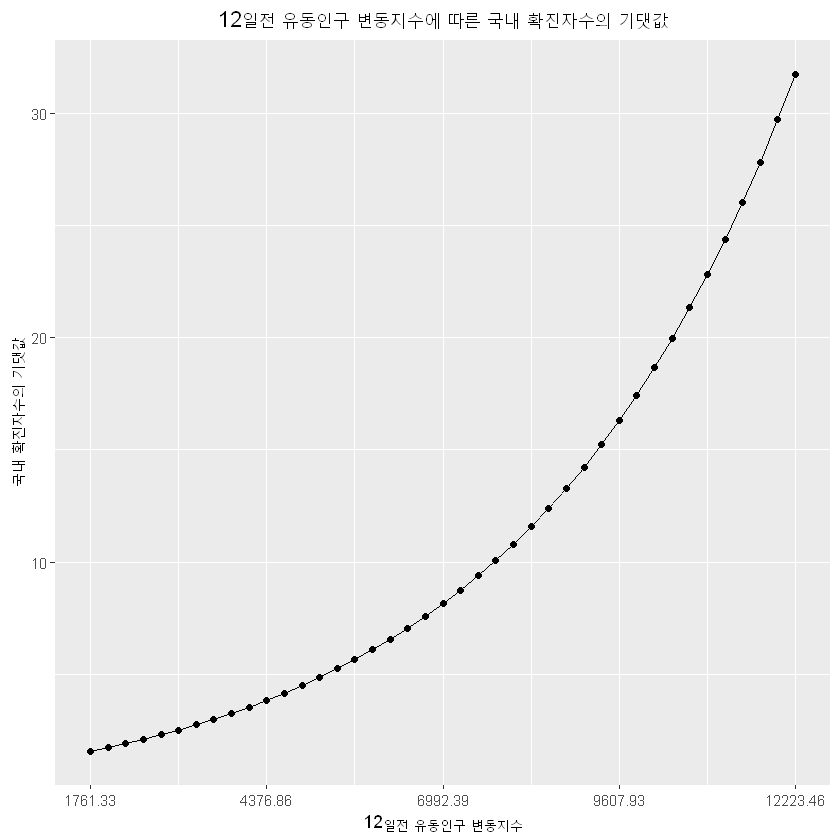

In [42]:
li_ <- c(-2, -1, 0, 1, 2)*real_sd+real_mean
ggplot(data = tmp, aes(x=x, y=y)) +
  geom_line() + geom_point() + labs(x="12일전 유동인구 변동지수", y="국내 확진자수의 기댓값") + scale_x_continuous(labels = round(li_,2))+ggtitle("12일전 유동인구 변동지수에 따른 국내 확진자수의 기댓값") +
 theme(plot.title = element_text(hjust = 0.5))

- 다른 변수들이 다 평균값이라고 하였을때, 12일전 유동량(유동인구 변동지수)에 따른 국내 확진자수의 기댓값을 함수로 표현해본 것입니다. 
- 12일전 유동량(유동인구 변동지수)이 증가하면, 당일 국내 확진자수가 지수적으로 증가함을 확인할 수 있습니다. 다만, 이 기댓값은 추정치일 뿐이므로, 신뢰구간을 추가적으로 구해보았습니다.

In [43]:
#confidence interval of E(national_patient)

newdata<-data.frame(humidity_lag2=0,temp_lag13=0,humidity_lag6=0,humidity_lag13=0,temp_lag1=0,rain_lag3=0,rain_lag2=0,temp_lag2=0,traffic_lag12=0,temp_lag7=0)
len<-length(li)-1

for(i in 1:len){
    new<-c(0,0,0,0,0,0,0,0,0,0)
    newdata<-rbind(newdata,new)
}

newdata$traffic_lag12 <- li

In [44]:
lw<-exp(predict(model,newdata,interval="confidence")[,2])-1 #신뢰구간 하한
up<-exp(predict(model,newdata,interval="confidence")[,3])-1 #신뢰구간 상한

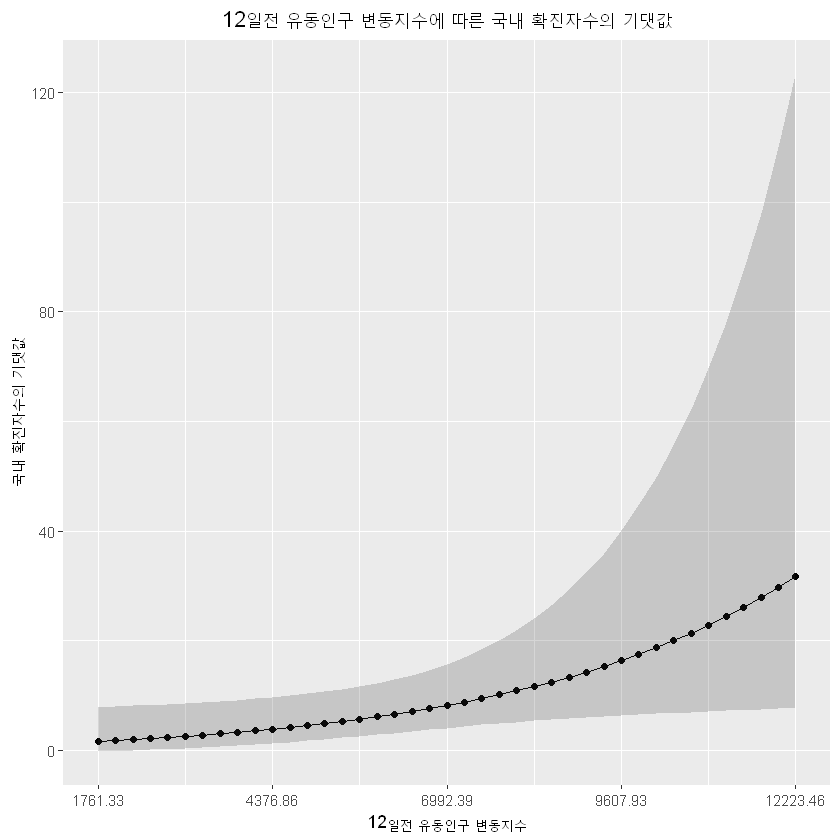

In [45]:
li_ <- c(-2, -1, 0, 1, 2)*real_sd+real_mean
ggplot(data = tmp, aes(x=x, y=y)) +
  geom_line() + geom_point() + labs(x="12일전 유동인구 변동지수", y="국내 확진자수의 기댓값") + scale_x_continuous(labels = round(li_,2)) +
geom_ribbon(aes(ymin=lw, ymax=up),alpha=0.2) + ggtitle("12일전 유동인구 변동지수에 따른 국내 확진자수의 기댓값") +
theme(plot.title = element_text(hjust = 0.5))

- 다른 설명변수들(2일전, 6일전, 13일전 습도, 1일전, 2일전, 7일전, 13일전 기온, 2일전, 3일전 강수량)이 평균치일때, 12일전 유동량(유동인구 변동지수)이 6992.39일 경우 4명 이상 16명 이하의 확진자가 생길것으로 기대되며, 12223.46일 경우 8명 이상 123명 이하의 확진자가 생길것으로 기대됩니다. 
- 즉 12일전에 시간당 평균 유동량이 증가함에 따라 당일날 확진자수가 지수적으로 증가함을 확인할수 있었습니다. 
- **따라서 사회적 거리두기가 확실히 확진자수의 감소에 도움을 주는 것을 확인할수 있었습니다.**

------

- **<span style="color:blue">긴 글 읽어주셔서 감사합니다.</span>**
- **<span style="color:blue">본 게시글에서는 사회적 거리두기가 확진자 증폭의 예방 역할을 할 수 있는지 분석한 결과를 말하고 있습니다.</span>**
- **<span style="color:blue">다들 갑작스런 전염병의 확산에 길어진 방콕 생활이 지겨워지셨을거라 생각합니다. 하지만 우리 모두 조금만 더 힘내었으면 좋겠습니다.</span>**
- **<span style="color:blue">참고로 위에서 보인 연구 결과는 데이터의 부족으로 인해(유동량 데이터가 2월 29일까지만 존재) 편향이 다소 존재할수는 있습니다.</span>**
- **<span style="color:blue">이후에 추가되는 데이터를 사용하여 위의 연구를 갱신할 예정입니다. 그리고 정부의 사회적 거리두기 정책이 유동량의 감소에 정말로 긍정적인 영향을 미쳤는지 베이지안 상태공간모형을 이용하여 밝혀낼 예정입니다.</span>**

![legend of logo](http://teamconfidence.dothome.co.kr/wp-content/uploads/2020/04/logo-1.png)

지금까지 팀 컨피던스였습니다 :D